In [2]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

# for models
from catboost import CatBoostClassifier as cbclf
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import  f1_score, classification_report
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import shap

from sklearn.linear_model import LogisticRegression

# display all the columns and rows 
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)
# set figure size for single graphs 
plt.rcParams['figure.figsize'] = [15, 6]

In [3]:
df = pd.read_csv('/kaggle/input/final-df-generation/final_df.csv')
df

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_tl,num_il_tl,pct_tl_nvr_dlq,total_bc_limit,fico_diff
0,12000.0,36 months,7.97,4.0,10+ years,OWN,42000.0,Source Verified,Fully Paid,debt_consolidation,...,1.0,0.0,14.0,0.0,6.0,2.0,7.0,100.0,15500.0,4.0
1,10000.0,36 months,9.44,5.0,3 years,MORTGAGE,55000.0,Not Verified,Fully Paid,debt_consolidation,...,10.0,2.0,49.0,0.0,2.0,1.0,5.0,100.0,10500.0,4.0
2,12800.0,36 months,13.59,11.0,5 years,RENT,90000.0,Not Verified,Fully Paid,debt_consolidation,...,5.0,0.0,5.0,0.0,6.0,6.0,15.0,83.0,14750.0,4.0
3,15000.0,36 months,13.59,11.0,4 years,MORTGAGE,180000.0,Source Verified,Fully Paid,medical,...,13.0,4.0,16.0,0.0,14.0,16.0,17.0,100.0,116700.0,4.0
4,40000.0,60 months,7.97,4.0,10+ years,OWN,200000.0,Verified,Charged Off,home_improvement,...,0.0,6.0,28.0,0.0,6.0,10.0,35.0,100.0,48400.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903811,24000.0,60 months,23.99,21.0,< 1 year,RENT,107000.0,Source Verified,Charged Off,other,...,4.0,0.0,18.0,1.0,7.0,11.0,5.0,87.5,28200.0,4.0
903812,10000.0,36 months,7.99,4.0,10+ years,MORTGAGE,65000.0,Source Verified,Fully Paid,debt_consolidation,...,1.0,0.0,1.0,0.0,8.0,12.0,4.0,92.6,34800.0,4.0
903813,10050.0,36 months,16.99,15.0,8 years,RENT,37000.0,Not Verified,Charged Off,debt_consolidation,...,2.0,0.0,6.0,0.0,13.0,4.0,3.0,95.2,9000.0,4.0
903814,6000.0,36 months,11.44,8.0,5 years,RENT,41000.0,Source Verified,Fully Paid,credit_card,...,12.0,0.0,32.0,0.0,3.0,4.0,9.0,94.4,8100.0,4.0


In [6]:
# Import data
# Columns no.(1,48,58,117,127,128,129,132,133,134,137) have mixed types, so low_memory=False is included
raw_data = pd.read_csv('../input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip', low_memory=False)

This project use the most popular approach of the Cross-Industry Standard Process for Data Mining (CRISP-DM), (Wirth et al.,2000, p.6). The framework as below:

1. Problem statement/Business understanding

2. Data Understanding (Exploratory Data Analysis)

3. Data Preparation

4. Modeling development

5. Evaluation/Interpretation

6. Communication/Deployment

Source: Wirth, R. & Hipp, Jochen. (2000). CRISP-DM: Towards a standard process model for data mining. Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining. 

# PROBLEM STATEMENT

LendingClub company provides P2P lending, which becomes more and more popular. Investors are responsible for their own decision on lending. Even though the company has fitter borrowers who meet the minimum requirements, there is still a huge risk of non-repayment. This is the problem that this project works on by making the prediction of loan status for these people.

The final product of this project is a localhost web app that presents an explanation dashboard of a predictive model to classify which customers fall into categories of 'Fully Paid' or Charged Off'. End-users can understand the model as well as receive predictive results for a new customer.

In brief, this project is created with the purpose of:
- improving profitability for the lenders
- providing a lightweight tool to support the process of decision making
- an app with an easily used interface

# EXPLORATORY DATA ANALYSIS (EDA)

## About the dataset

### General information

* Data is collected originally from LendingClub data website. The LendingClub Notes platform retired on December 31, 2020 (https://www.lendingclub.com/investing/peer-to-peer), so the accuracy of this data sample solely depends on the collection of individuals on Kaggle. 

* Content: The personal information of customers is collected during the membership, application process and from credit bureaus such as date of birth, income, account information, credit history and credit score, credit card and other debt information.

* Overall information of the dataset:
    - Source: https://www.kaggle.com/ethon0426/lending-club-20072020q1?select=Loan_status_2007-2020Q3.gzip, the zipped file contains a *.gzip file of data and an excel file of feature description.
    - Duration: 2007-2020
    - Context: data is collected from customers in US
    (https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan) ?
    - Currency: USD
    - Types of features:
        - Loan Characteristics such as loan amount, term and purpose
        - Demographic data such as employment status, employment length and house ownership
        - Behavioral data related to historical payments

Because the problem to solve here is prediction for loan outcomes before it is granted, so the features provided before a loan is granted will be focus on, and the rest will be ignored.

In [7]:
# create a copy of data to work on, avoiding modifying the original dataset
df = raw_data.copy()
# first look of the data
df.head().transpose()

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
id,1077501,1077430,1077175,1076863,1075358
loan_amnt,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amnt,5000.0,2500.0,2400.0,10000.0,3000.0
funded_amnt_inv,4975.0,2500.0,2400.0,10000.0,3000.0
term,36 months,60 months,36 months,36 months,60 months
int_rate,10.65%,15.27%,15.96%,13.49%,12.69%
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B
sub_grade,B2,C4,C5,C1,B5


In [8]:
# drop 'Unnamed: 0', which is a redundant index columns available in the origin data
df.drop(columns=['Unnamed: 0'], inplace=True)

# check the initial dimension of the data
df.shape

(2925493, 141)

The dataset contains 2925493 rows and 141 columns.

# Exploratory Data Analysis

### Numerical data

In [9]:
# descriptive analysis
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,2925492.0,15358.775105,9478.383451,5.000000e+02,8000.0000,13000.000000,20000.000000,4.000000e+04
funded_amnt,2925492.0,15354.704909,9477.144689,5.000000e+02,8000.0000,13000.000000,20000.000000,4.000000e+04
funded_amnt_inv,2925492.0,15340.046287,9480.634495,0.000000e+00,8000.0000,13000.000000,20000.000000,4.000000e+04
installment,2925492.0,452.391358,272.947849,4.930000e+00,253.5000,382.300000,603.920000,1.719830e+03
annual_inc,2925488.0,79937.274015,111747.608711,0.000000e+00,47000.0000,66000.000000,95000.000000,1.100000e+08
dti,2922384.0,19.296480,15.719773,-1.000000e+00,12.0800,18.100000,24.880000,9.990000e+02
delinq_2yrs,2925463.0,0.289701,0.843682,0.000000e+00,0.0000,0.000000,0.000000,5.800000e+01
fico_range_low,2925492.0,700.511030,33.765652,6.100000e+02,675.0000,695.000000,720.000000,8.450000e+02
fico_range_high,2925492.0,704.511235,33.766533,6.140000e+02,679.0000,699.000000,724.000000,8.500000e+02
inq_last_6mths,2925462.0,0.554213,0.859975,0.000000e+00,0.0000,0.000000,1.000000,3.300000e+01


* Descriptive statistics for each of the numerical variable show the mean, standard deviation, minimum & maximum values and values which fall within 25/50/75% of the total data. Standard deviation measures how dispersed the data is in relation to the mean. Low std indicates that data is clustered around the mean, high std means that data is spread out.

* Variables with significantly higher standard deviation (than the rest) are:
    tot_hi_cred_lim, 
    tot_cur_bal, 
    annual_inc, 
    annual_inc_joint, 
    total_bal_ex_mort, 
    total_il_high_credit_limit, 
    total_bal_il, 
    total_rev_hi_lim, 
    revol_bal_joint, 
    total_bc_limit, 
    revol_bal, 
    bc_open_to_buy, 
    avg_cur_bal, 
    total_pymnt, 
    total_pymnt_inv, 
    funded_amnt_inv, 
    loan_amnt, 
    funded_amnt, 
    hardship_payoff_balance_amount, 
    tot_coll_amt, 
    out_prncp, 
    out_prncp_inv, 
    total_rec_prncp, 
    max_bal_bc, 
    last_pymnt_amnt, 
    total_rec_int, 
    hardship_last_payment_amount, 
    recoveries.

* Among many features, only last_pymnt_amnt column contains negative values (check the min values)

* Columns related to payment history are the ones which have the most missing values(check the column of count):
    mths_since_last_delinq, 
    mths_since_last_major_derog, 
    mths_since_recent_bc_dlq, 
    mths_since_last_record, 
    annual_inc_joint, 
    dti_joint, 
    sec_app_num_rev_accts, 
    sec_app_open_acc, 
    sec_app_open_act_il, 
    sec_app_mort_acc, 
    sec_app_inq_last_6mths, 
    sec_app_collections_12_mths_ex_med, 
    sec_app_chargeoff_within_12_mths, 
    sec_app_fico_range_low, 
    sec_app_fico_range_high, 
    revol_bal_joint, 
    sec_app_revol_util, 
    hardship_payoff_balance_amount, 
    hardship_last_payment_amount, 
    hardship_amount, 
    orig_projected_additional_accrued_interest, 
    deferral_term, 
    hardship_length, 
    hardship_dpd.

* Some of the noticeble features will be examined as below. 

##### FICO scores

There are 2 variable with the similar content is fico_range_low and fico_range_high, so a transformation is needed.

In [11]:
# remove '%' and convert 'interest' into numeric type
df['int_rate'] = df['int_rate'].str.replace('%','')
df['int_rate'] = pd.to_numeric(df['int_rate'])

In [12]:
# examine the difference between fico_range_high and fico_range_low
df['fico_diff'] = df['fico_range_high'] - df['fico_range_low']
df['fico_diff'].value_counts()

4.0    2924892
5.0        600
Name: fico_diff, dtype: int64

### Categorical data

##### grade and sub-grade

In [15]:
subgrades = list(df.sub_grade.sort_values().unique())
subgrades_int_mapping = dict(zip(subgrades, list(range(len(subgrades)-1))))
df.replace({'sub_grade': subgrades_int_mapping}, inplace=True)
df.sub_grade.value_counts()

8.0     185188
9.0     181856
10.0    179073
6.0     164880
5.0     163455
7.0     162194
11.0    161790
12.0    159015
3.0     158426
4.0     157156
13.0    153184
14.0    149218
0.0     133282
16.0    108645
2.0     106377
1.0     101061
15.0    100822
17.0     83075
18.0     67101
19.0     56637
20.0     34838
21.0     30346
22.0     27229
24.0     23404
23.0     23219
25.0     13425
26.0      9314
27.0      7794
28.0      6129
29.0      5174
30.0      4113
31.0      2697
32.0      2095
33.0      1712
34.0      1568
Name: sub_grade, dtype: int64

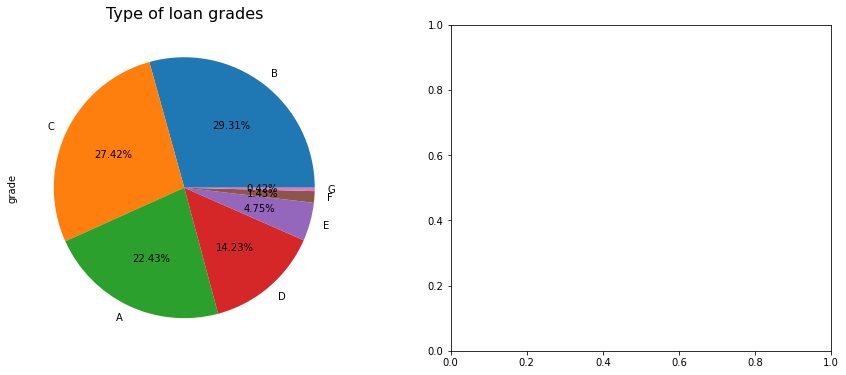

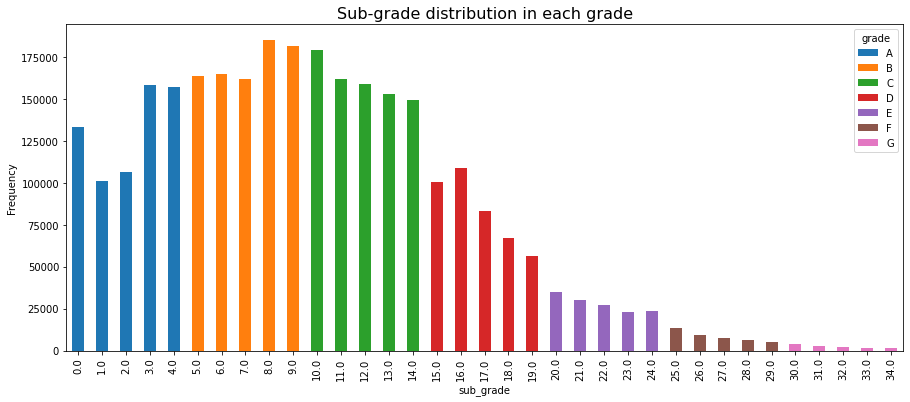

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# grade
df['grade'].value_counts().plot.pie(ax=axs[0], autopct='%.2f%%')
axs[0].set_title('Type of loan grades', fontsize=16)


#### Grade vs sub_grade, using crosstab function to count the frequency
pd.crosstab(df['sub_grade'], df['grade']).plot(kind='bar', stacked=True)
plt.title('Sub-grade distribution in each grade', fontsize=16)
plt.ylabel('Frequency')
plt.show()

* As for the loan grade, the majority types are A, B and C, which respectively accounts for about 20%, 31% and 28% of total number of grade types. 
* There are 35 sub-grades in total. Rated loans B3, C1, B4 and B2 the most common one compared to the rest of the sub-grades.
* The third bar chart show that in grade B, D, C and E, the difference in the number of its sub-grades is not significant when compared that in grade A. 

##### emp_length, home ownership, and verification status

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# employment length plot
df['emp_length'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0])
axs[0].set_title('Employment length of borrowers (in year)', fontsize=16)
axs[0].set_ylabel("%")

# verification status plot
df['verification_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Verification status', fontsize=16)
axs[1].set_ylabel("%")

# Home ownership plot
df['home_ownership'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[2])
axs[2].set_title('Home ownership categories', fontsize=16)
axs[2].set_ylabel("%")

# all the units ae percentage

* Employment length is collected in applications. A significant high percentage (nearly 35%) of the applicants works for a long time of more than 10 years. Moreover, the people who have no jobs or less than 1-year employment accounts for the second highest figures (about 10%) compared to the rest. The number of people with 9 year working accounts for the least (below 5%).

* The next graph representing verification status shows that most of the applicants' income information will be verified (by the company itself or the source is already verified). There is 40% of the applicants' incomes is not verified at the time of exporting data.

* Home ownership bar graph: the most dominating type of ownership is "mortgage" and "rent", which also reflects the reality in US that the majority of citizens do not own theirs properties.

In [ ]:
# filter out the applicants who have Not Verified status for their income 
vf = df[(df.verification_status == 'Not Verified')]

# present in transposed style
vf.head().T 

Note: A sufficient income is the minimum requirement of applying to any loans, but in LendingClub unverified status does not mean that borrowers are rejected right away, and these applicant can still get a loan (as can be seen from from the table). Investors can take risk by offering these unverified income applicants with lower amount as long as there will be proves of other items such as bank statements or FICO scores, for example, to make sure that one can repay a loan.

(Source: Qualifying for a personal loan. Lendingclub Q&A. https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan. Last access 27.02.2022)

##### initial_list_status, loan_status and application_type

Text(0.5, 1.0, 'Application type')

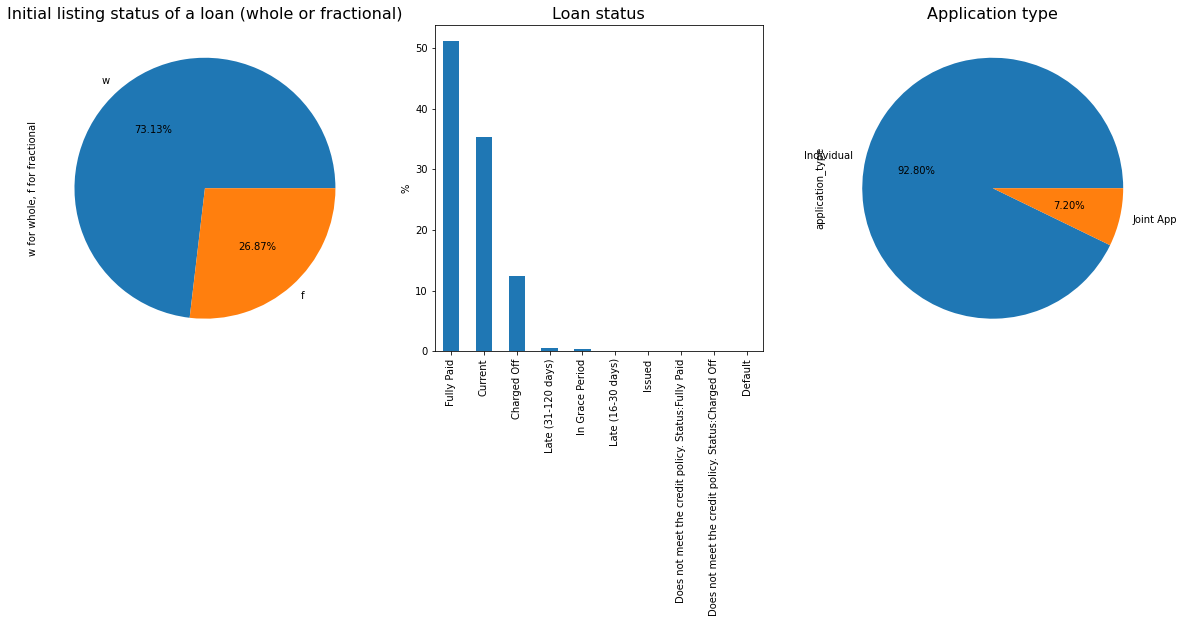

In [19]:
# the graphs for "initial list status", "loan status" and "application type" are plotted below
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 1st graph
df['initial_list_status'].value_counts().plot.pie(ax=axs[0],autopct='%.2f%%')
axs[0].set_title('Initial listing status of a loan (whole or fractional)', fontsize=16)
axs[0].set_ylabel("w for whole, f for fractional")

# 2nd graphs
df['loan_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Loan status', fontsize=16)
axs[1].set_ylabel("%")

# 3rd graph
df['application_type'].value_counts().plot.pie(ax=axs[2],autopct='%.2f%%')
axs[2].set_title('Application type', fontsize=16)

* The first pie chart represents the division between "whole" and "factorial". There are 2 classes of investors on the lending platform of LendingClub: institutional (corresponding to whole loan purchasers) and retail (fractional or note purchasers). It can be seen that most of the loan are from institutional investors double the number of loans that comes from retail investors, respectively at around 61% and 39%.

* For loan_status label understanding:
    - Current: Loan is up to date on all outstanding payments. 
    - In Grace Period: Loan is past due but within the 15-day grace period. 
    - Late (16-30): Loan has not been current for 16 to 30 days. 
    - Late (31-120): Loan has not been current for 31 to 120 days. 
    - Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
    - Default: Loan has not been current for an extended period of time.
    - Charged Off: Loan for which there is no longer a reasonable expectation of further payments.

(Source: What do the different Note statuses mean?. Lendingclub Q&A. https://help.lendingclub.com/hc/en-us/articles/215488038. Last access 27.02.2022)

    From the bar chart, there is a significant number of people who have a loan status of Current (about 30%) and Fully Paid (55%). This also means 55% of the people who apply for loan can payback successfully. The status of Charged Off only accounts for around 14% and the percentage of Late or Default borrowers is extremely low, 1% or under 1%. Loan status is an important variable which will be examined closer in the next part. 
    
* For the classes of status that do not meet the credit policy: LendingClub has its credit policy if customers meet its threshold criteria to access loans, but investor still can consider other factors to offer another type of loans. We ignore the policies and may consider:
- Does not meet the credit policy. Status:Fully Paid: as Fully paid.
- Does not meet the credit policy. Status:Charged Off: Similarly, as Charged Off

* The final chart is about the types of applications: "individual" or "joint". Majority of the applicants, about 91%, are individuals. Only 9% are "joint" applications (two people apply for one loan and are responsible for it together).

##### addr_state and emp_title

Text(0.5, 0, 'state')

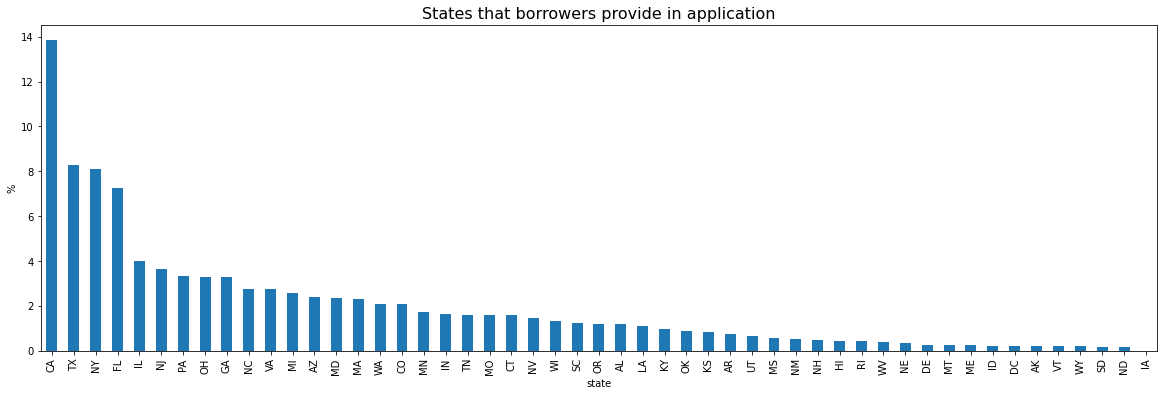

In [20]:
# count the frequency of states where the applicants live in  
df['addr_state'].value_counts(normalize=True).mul(100).plot.bar(figsize=(20, 6))
plt.title('States that borrowers provide in application', fontsize=16)
plt.ylabel("%")
plt.xlabel("state")

The main takeaway from the graph is there is a significant number of applicants resident in 'CA' or California (about 15%), and the following are 'NY', 'TX' and 'FL' (stands for New York, Texas and Florida) which accounts for around 8% each. There is barely a loan offered in IA or Iowa state. About the other states, each takes up very small percentage (smaller than 4%).

In [22]:
#the "employment title" shows what employment position most of the borrowers hold
df['emp_title'].value_counts().head(10)

Teacher             50103
Manager             43731
Owner               24792
Registered Nurse    20732
Driver              19676
RN                  18420
Supervisor          17971
Sales               16063
Project Manager     14096
Office Manager      12810
Name: emp_title, dtype: int64

The results show that top 5 employment titles are Teachers, Managers, Owner, Driver and Registered Nurse.

##### Related to hardship

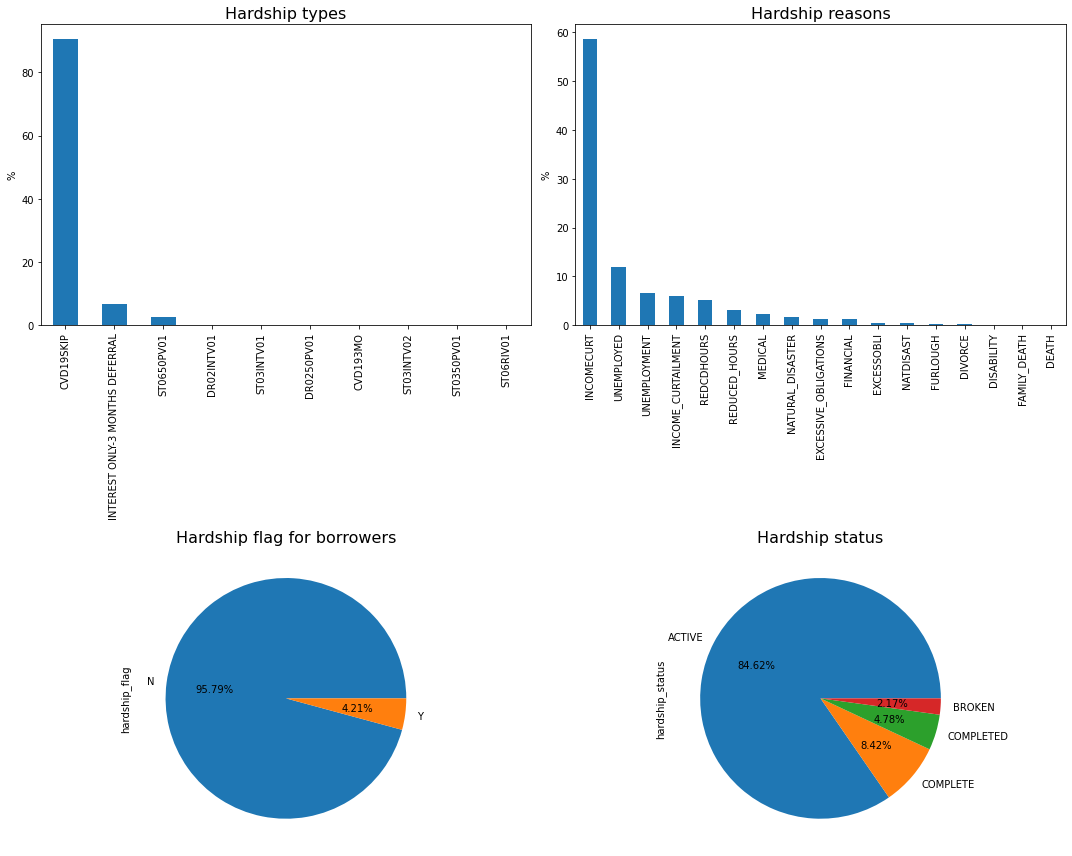

In [23]:
# Plot hardship_type, hardship_reason, and hardship_flag
fig, axs = plt.subplots(2, 2, figsize=(15,12))

# 1st plot
df['hardship_type'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,0])
axs[0,0].set_title('Hardship types', fontsize=16)
axs[0,0].set_ylabel("%")

# 2nd plot
df['hardship_reason'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,1])
axs[0,1].set_title('Hardship reasons', fontsize=16)
axs[0,1].set_ylabel("%")

# 3rd plot
df['hardship_flag'].value_counts().plot.pie(ax=axs[1,0], autopct='%.2f%%')
axs[1,0].set_title('Hardship flag for borrowers', fontsize=16)

# 4th plot
df['hardship_status'].value_counts().plot.pie(ax=axs[1,1], autopct='%.2f%%')
axs[1,1].set_title('Hardship status', fontsize=16)
plt.tight_layout()

* Hardship payment is the program providing a chance to people who are struggling to meet your basic needs or bear young/small children. There are 9 hardship types offered by LendingClub. There is little information about this so we will not do more analysis on hardship_type.

* The second graph shows the reason for the hardship. The main reasons why borrowers apply to a hardship plan are income curtailment (nearly 60%) and being unemployed (about 12%). 

* The 2 last graphs: There is only 3.65% of applicants enroll into hardship program. Among these, at the time of exporting data 84% of hardship plans is active, the rest of 15% includes pending, canceled, completed, and broken status.

## Bivariate EDA

In this part we will try to answer some questions related to the relationship between 2 variables.

### Loan status

* There are 7 classes left in the columns of loan_status. 

* Based on the EDA, the definitions of Fully Paid, Charged Off and Default are clear. For the other classes, it is noticeable that:  
    - Current: means all payments are made on time
    - In Grace Period: duration of 15 days extended after the due date that borrowers can pay back without extra fee/fine
    - Late (31-120 days), Late (16-30 days): borrowers fail to make payment within the grace period

* We have not known the outcomes from the status of Current, In Grace Period and Late yet, so these classes should be removed from the target column of loan status. Because in the end we want to know if the borrower can pay back loan amount or not, the classes of Fully Paid, Charged Off and Default should be in attention. There is a slight difference between Default and Charge off. Default is when a borrower fails to pay back after the Late period of 120 days, but the company can work with a third party to collect the rest of the debt. For Charged Off, it is the worst state that no investors expected because no further payments can be made, so this class will be chosen for prediction.

* In brief, we are solving a binary classification problem, and the model will be trained to classify 2 outcomes only: Fully paid and Charged Off. 

In [39]:
# filter out a list of other classes besides 'Fully Paid' and 'Charged Off' by finding the difference between 2 sets
a = list(df.loan_status.unique())
b = ['Fully Paid', 'Charged Off']
c = list(set(a) - set(b))

# remove unnessary values using list c
for k in c:
    del_index = df[df['loan_status'] == k].index
    df.drop(del_index, inplace=True)
print(df.loan_status.value_counts())

Fully Paid     1497783
Charged Off     362548
Name: loan_status, dtype: int64


#### loan_status and term

In [40]:
# create a crosstab to count the frequency of terms in each loan status
pd.crosstab(df['loan_status'], df['term'], normalize="index").mul(100)
# unit: percentage

term,36 months,60 months
loan_status,,
Charged Off,60.045015,39.954985
Fully Paid,78.489808,21.510192


Text(0, 0.5, '%')

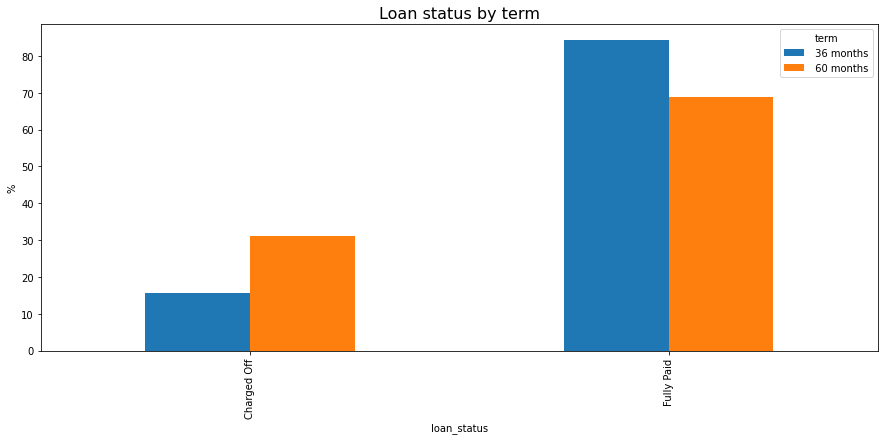

In [42]:
# visualize from crosstab
pd.crosstab(df['loan_status'], df['term'], normalize="columns").mul(100).plot(kind='bar')
plt.title('Loan status by term', fontsize=16)
plt.ylabel('%')

The graph shows that the loan term of 36 months are more than twice as many as the loan term of 60 months for the people who hold status of Charged Off, Current, Default, In Grace Period and Late. Meanwhile, in the status of 'Does not meet the credit policy. Status:Charged Off' and 'Does not meet the credit policy. Status:Fully Paid', the number of applications with 36 month term is significantly higher than that of 60 month term. In general, the number of the 36 month term application is always less than the 60 month term application in each loan status. 

#### loan_status and grade

In [43]:
pd.crosstab(df['loan_status'], df['grade'], normalize='columns')

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,0.064533,0.135136,0.223587,0.300912,0.375914,0.44384,0.489949
Fully Paid,0.935467,0.864864,0.776413,0.699088,0.624086,0.55616,0.510051


Text(0, 0.5, '%')

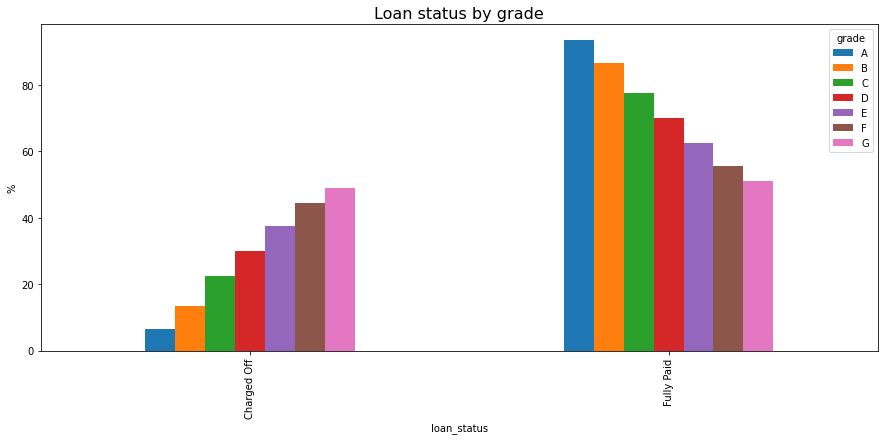

In [44]:
# the frequency of crosstab already converted into percentage
pd.crosstab(df['loan_status'], df['grade'], normalize='columns').mul(100).plot(kind='bar', stacked=False)
plt.title('Loan status by grade', fontsize=16)
plt.ylabel('%')

* The graph show clearly that higher grade implies less charging off

#### loan_status and home_ownership

In [45]:
# create crosstab with normalized data in each loan status
pd.crosstab(df['loan_status'], df['home_ownership'], normalize='columns').mul(100)

home_ownership,ANY,MORTGAGE,NONE,OTHER,OWN,RENT
loan_status,,,,,,
Charged Off,20.357751,16.831186,14.285714,18.75,20.107696,22.631562
Fully Paid,79.642249,83.168814,85.714286,81.25,79.892304,77.368438


It can be seen from the table that in each loan status, number of people having house mortgages are always majority, accounting for around 46% on average. 

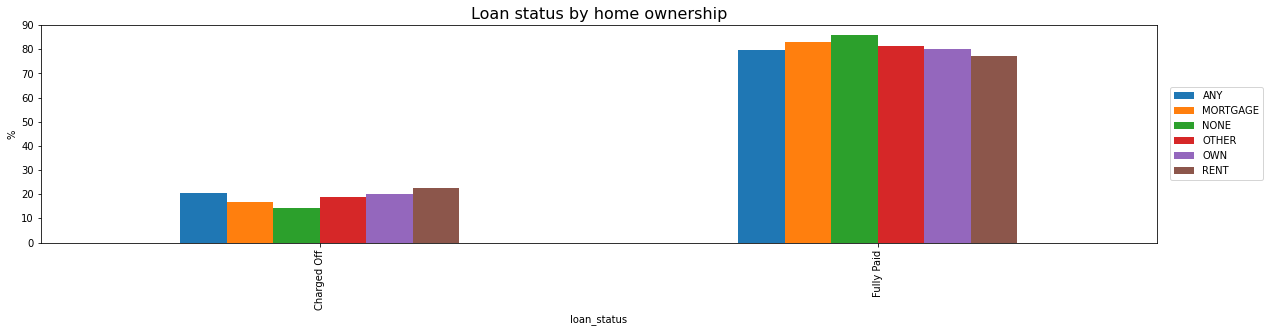

In [46]:
# visualize from the crosstab table
pd.crosstab(df['loan_status'], df['home_ownership'], normalize='columns').mul(100).plot(kind='bar', figsize=(20, 4))
plt.title('Loan status by home ownership', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

* Only in the categories of Charged Off and Late (31-120 days) the percentage of people who rent houses are larger than the people have houses with mortgages. Meanwhile, the percentage of people who rent houses is nearly equal to that of having houses with mortgage, and in the other loan status, 'Mortgage' is more frequently observed than 'Rent'.
* In conclusion, it is hard to conclude if there is a specific type of house ownership having a significant effect on a loan status.

#### loan_status and verification_status

In [47]:
# create crosstab with normalized data in each loan status
pd.crosstab(df['loan_status'], df['verification_status'], normalize='index').mul(100)

verification_status,Not Verified,Source Verified,Verified
loan_status,,,
Charged Off,24.550404,40.792943,34.656652
Fully Paid,33.339543,39.136110,27.524348


Text(0, 0.5, '%')

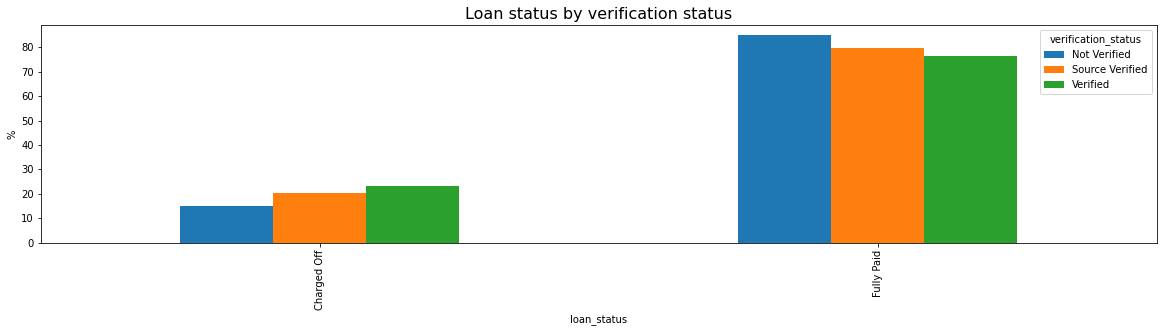

In [48]:
# visualize
pd.crosstab(df['loan_status'], df['verification_status'], normalize='columns').mul(100).plot(kind='bar', figsize=(20, 4))
plt.title('Loan status by verification status', fontsize=16)
plt.ylabel('%')

* About 28% of people who have Charged Off status have the income unverified. This means that even with income verified, a person can still have the incapacity of paying back a loan.
* Late(16-30 days), Late(31-120 days), and In Grace Period categories have a similar pattern that the percentage of Not verified is nearly equal to that of Source verified. 
* In conclusion, income verification is one of the factors to consider for loan applications. We cannot conclude that with unverified income a person cannot fully pay back his/her loan. 

#### loan_status and emp_length, and purpose

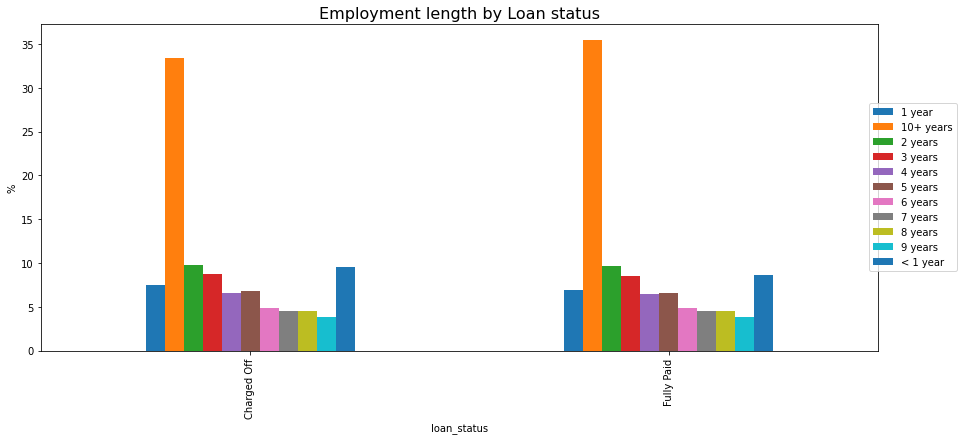

In [52]:
# loan status and employment length
pd.crosstab(df['loan_status'], df['emp_length'], normalize='index').mul(100).plot(kind='bar')
plt.title('Employment length by Loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

People who have more than 10 years of employment take up to about 32% on average in each loan status (not consider the case of Does not meet the credit policy). A similar pattern among different loan status is observed, with the fact that the percentage of people who apply for a loan without working or less than 1-year working comes in second place at around 10% in each category of status. 

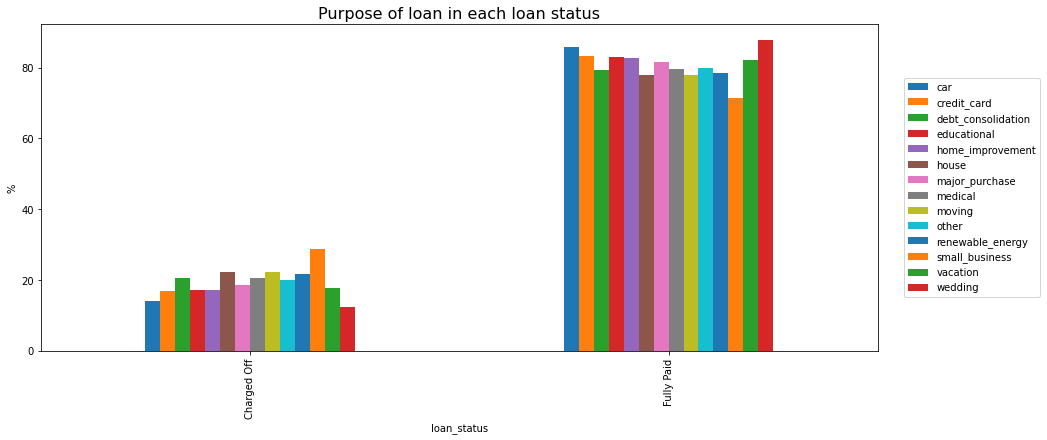

In [54]:
# loan status and purposes
pd.crosstab(df['loan_status'], df['purpose'], normalize='columns').mul(100).plot(kind='bar')
plt.title('Purpose of loan in each loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')

People who apply for loans because of debt consolidation are majority in each category, but normalizing by purpose of loan it can be observed that small business is the outlier among other purposes as nearly 25% of loans charged off in this category

Text(0.5, 0.98, 'Distribution of Employment length and Purpose in Charged Off status (respectively)')

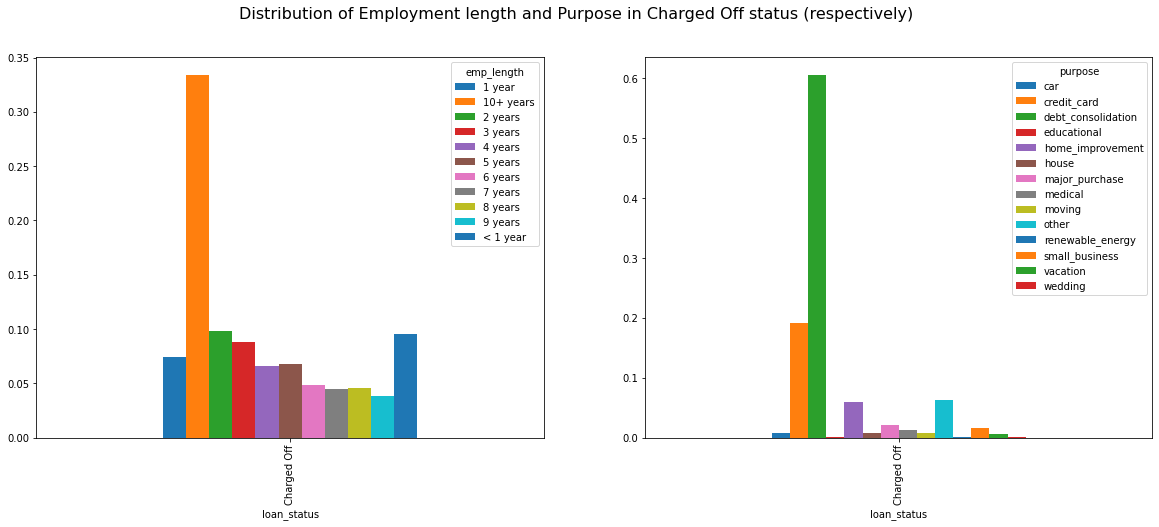

In [57]:
# a closer look at Charged Off status only
fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharex=True)
pd.crosstab(df['loan_status'], df['emp_length'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[0])
pd.crosstab(df['loan_status'], df['purpose'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[1])
fig.suptitle('Distribution of Employment length and Purpose in Charged Off status (respectively)', fontsize=16)

#### loan_status and open_acc/ total_acc

In this part only Charged Off and Fully Paid in loan status are focused on.

In [58]:
# create cross table with normalized values
df_1 = pd.crosstab(df['loan_status'], df['open_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)
df_2 = pd.crosstab(df['loan_status'], df['total_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)

In [60]:
df_1

open_acc,9.0,10.0,8.0,11.0,7.0,12.0,13.0,6.0,14.0,15.0,...,79.0,70.0,77.0,72.0,71.0,69.0,66.0,65.0,62.0,90.0
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,8.546730,8.459294,8.113133,7.932743,7.294207,7.160983,6.268963,6.001412,5.356532,4.551949,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
Fully Paid,8.816364,8.495223,8.513116,7.838051,7.748118,7.002817,6.110364,6.511224,5.235738,4.392959,...,0.000067,0.000067,0.000067,0.000134,0.000134,0.000134,0.0002,0.000401,0.000534,0.000067


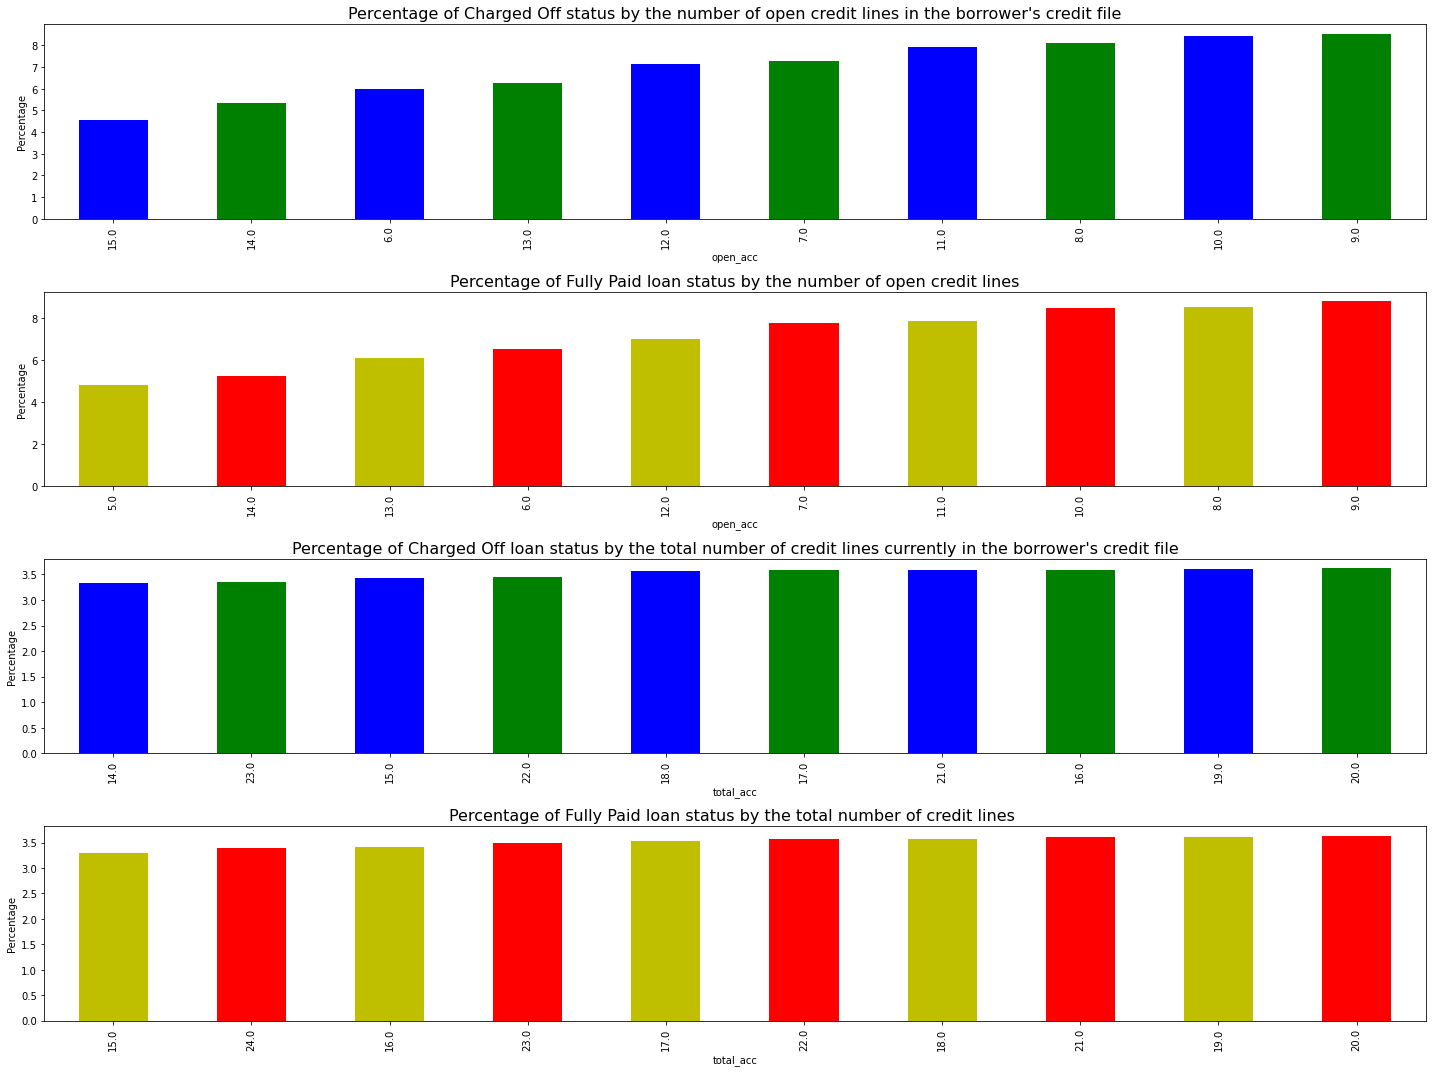

In [64]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))

# plot the sorted value from smallest to largest order
# the index of 0 or 5 is the order of Charged Off and Fully Paid columns in the crosstab table 
df_1.sort_values(axis=1, by='Charged Off').iloc[0,-10:].plot.bar(ax=axs[0], color=['b', 'g'])
df_1.sort_values(axis=1, by='Fully Paid').iloc[1,-10:].plot.bar(ax=axs[1], color=['y', 'r'])
df_2.sort_values(axis=1, by='Charged Off').iloc[0, -10:].plot.bar(ax=axs[2], color=['b', 'g'])
df_2.sort_values(axis=1, by='Fully Paid').iloc[1, -10:].plot.bar(ax=axs[3], color=['y', 'r'])

# set title for each graphs
axs[0].set_title("Percentage of Charged Off status by the number of open credit lines in the borrower's credit file", fontsize=16)
axs[1].set_title("Percentage of Fully Paid loan status by the number of open credit lines", fontsize=16)
axs[2].set_title("Percentage of Charged Off loan status by the total number of credit lines currently in the borrower's credit file", fontsize=16)
axs[3].set_title("Percentage of Fully Paid loan status by the total number of credit lines ", fontsize=16)

# set y_axis title
axs[0].set_ylabel("Percentage")
axs[1].set_ylabel("Percentage")
axs[2].set_ylabel("Percentage")
axs[3].set_ylabel("Percentage")

fig.tight_layout()

* Two first graph: Regardless of people who are listed as Charged Off or Fully Paid, the most popular numbers of open credit lines in the borrower's credit file are from 8 to 10.
* Two second graph: same, but 19 and 20 are most popular
* In general, people who have 30 credit lines are rare in the sample. Additionally, it cannot be concluded that there is a relationship about that having less/more credit lines (a borrowing limit) can clearly affect the ability to pay off loan.

##### loan_status and pub_rec/ pub_rec_bankruptcies

Text(0, 0.5, 'Frequency')

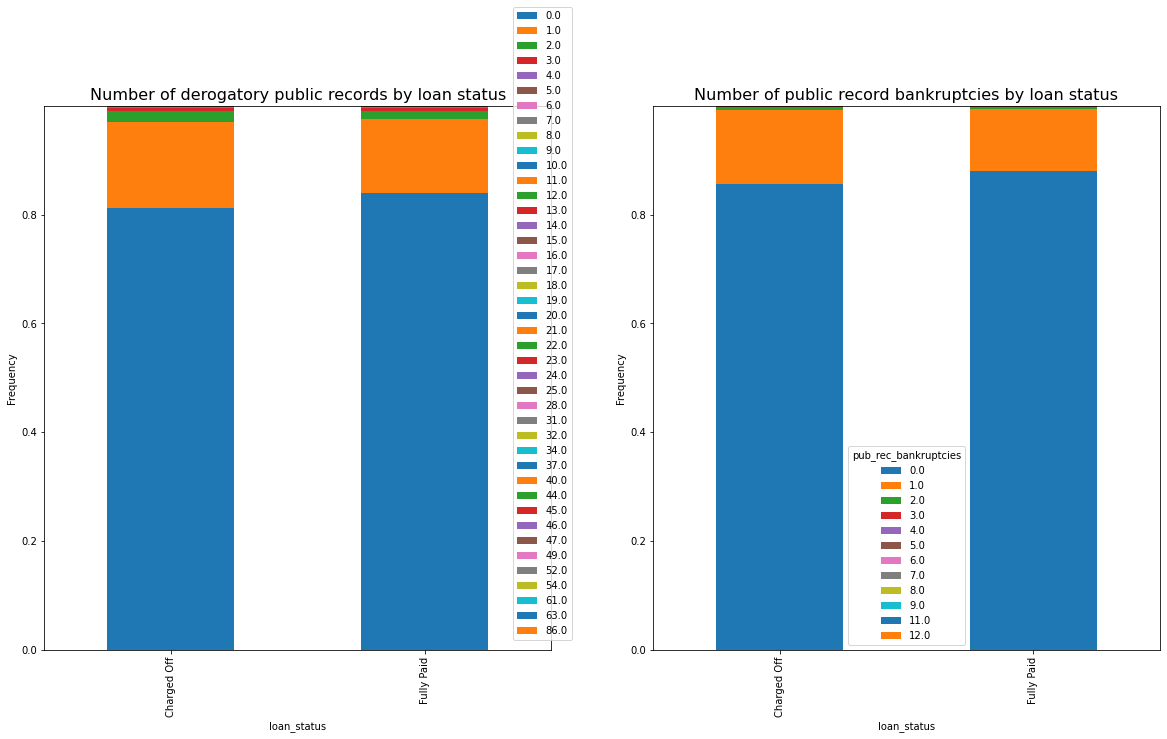

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) 

# loan status and number of derogatory public records
pd.crosstab(df['loan_status'], df['pub_rec'], normalize='index').plot(kind='bar',ax=axs[0], stacked=True)
axs[0].set_title('Number of derogatory public records by loan status', fontsize=16)
axs[0].set_ylabel("Frequency")
axs[0].legend(bbox_to_anchor=(1.05, 0.6), loc='right')

# loan status and number of public record bankruptcies
pd.crosstab(df['loan_status'], df['pub_rec_bankruptcies'], normalize='index').plot(kind='bar',ax=axs[1], stacked=True)
axs[1].set_title('Number of public record bankruptcies by loan status', fontsize=16)
axs[1].set_ylabel("Frequency")

There are a high similarity between 2 graphs about the negative behavioral payments. It can be seen that majority of the applicants have no public records of derogatory or bankruptcies.

#### Loan status and interest rate / loan amount

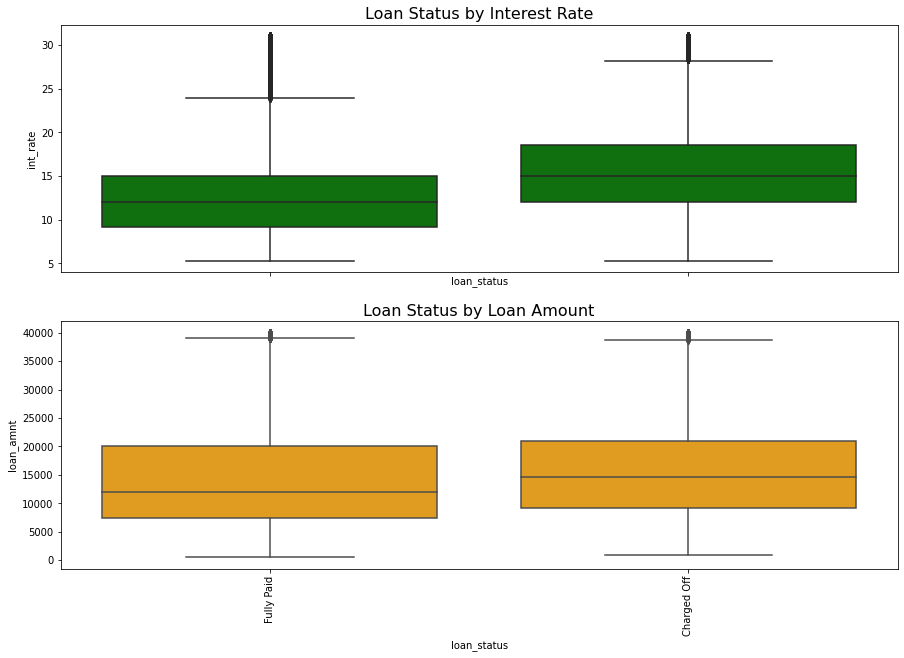

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# loan status and interest rate
sns.boxplot(x="loan_status", y="int_rate", data=df, color='g', ax=axs[0])
axs[0].set_title('Loan Status by Interest Rate', fontsize=16)

# loan status and loan amount
sns.boxplot(x="loan_status", y="loan_amnt", data=df, color='orange', ax=axs[1])
axs[1].set_title('Loan Status by Loan Amount', fontsize=16)
axs[1].tick_params(axis='x', rotation=90)

From both graphs we can see that:
* People who are in status of Charged Off and Default also the ones who hold a high interest rate (at about 15% on average). Meanwhile, the average of loan amount in these two status (at aroud 15000 USD) are pretty the same as that in other status except Fully Paid.
* People who can fully pay off loans have lower interest rate (around 13%) and lower amount of loan (about 12000 USD) compared to people with other status.

#### Loan status per state 

In [74]:
# create crosstab
df_st = pd.crosstab(df['loan_status'], df['addr_state'], normalize='columns')*100
df_st

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,18.954399,22.708132,23.5975,19.003252,19.45603,15.257335,17.838625,13.497472,18.912754,21.406813,...,20.116618,20.341722,19.454742,16.349725,19.273442,13.109677,15.344167,18.35025,14.913754,16.26506
Fully Paid,81.045601,77.291868,76.4025,80.996748,80.54397,84.742665,82.161375,86.502528,81.087246,78.593187,...,79.883382,79.658278,80.545258,83.650275,80.726558,86.890323,84.655833,81.64975,85.086246,83.73494


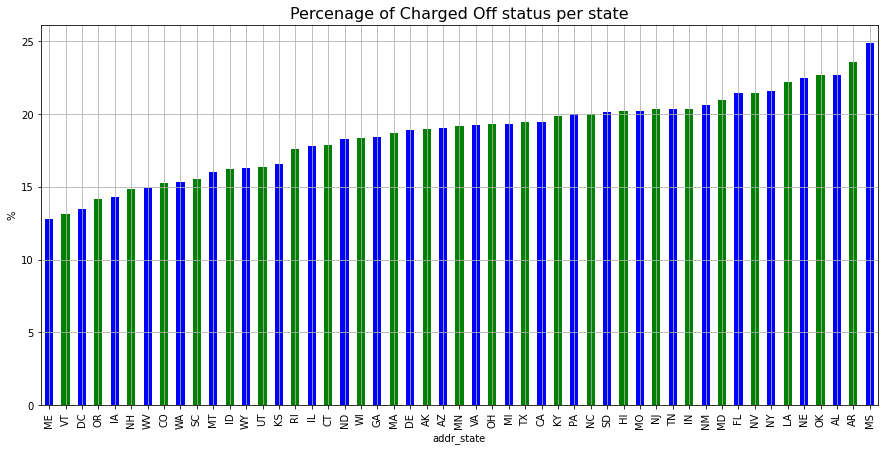

In [83]:
# visualize the above data
plt.figure(figsize=(15, 7))

df_st.sort_values(axis=1, by='Charged Off').iloc[0,:].plot.bar(color=['b', 'g'])

plt.grid()
plt.title('Percenage of Charged Off status per state', fontsize=16)
plt.ylabel("%")

fig.tight_layout()

Significant differentiation between different states

### Loan amount 

Text(0.5, 1.0, 'Loan amount distribution by term')

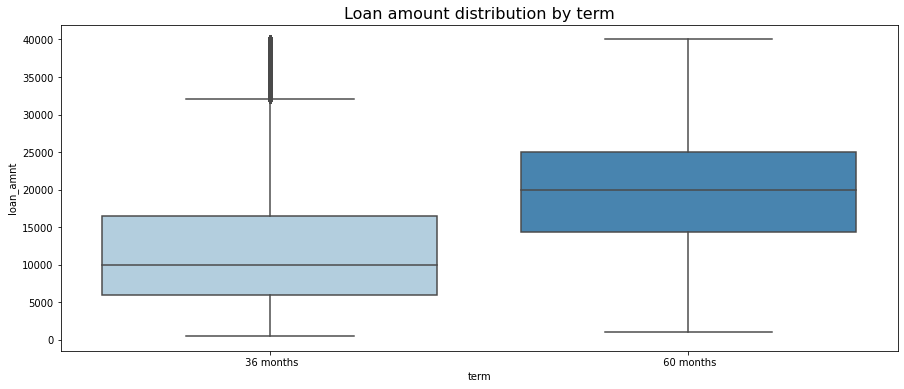

In [86]:
# plot using sns box plot
sns.boxplot(x='term', y='loan_amnt', data=df, palette="Blues")
plt.title('Loan amount distribution by term', fontsize=16)

The box plot graph above shows that the mean of 60 month loan amount (20000 USD) is higher than the mean of 36 month loan amount (10000 USD), which is reasonable that higher amounts of loan require longer time to be paid.

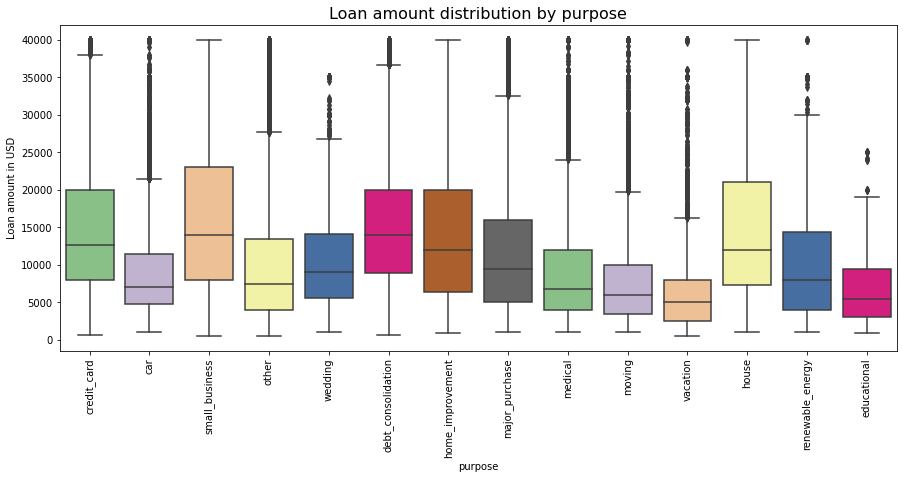

In [87]:
# distribution plot 
sns.boxplot(x='purpose', y='loan_amnt', data=df, palette="Accent")
plt.title("Loan amount distribution by purpose", fontsize=16)
plt.ylabel('Loan amount in USD')
plt.tick_params(axis='x', rotation=90)

* Compared the highest and lowest average loan amount among categories: People need around 15000 USD on average for the purpose of small business and debt_consolidation, while for vacation and educational purposes the amount of around 5000 USD is on request.

### Purpose

#### Purpose and term

Text(0, 0.5, '%')

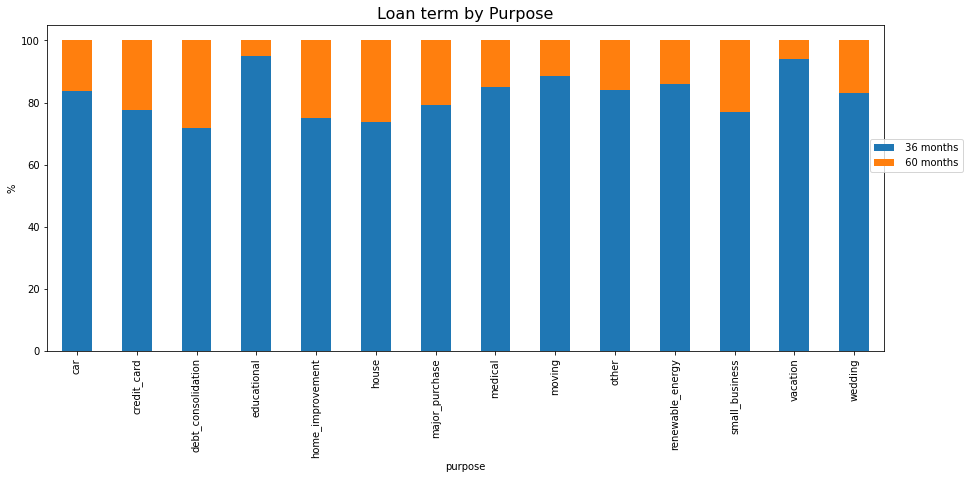

In [88]:
# plot from crosstab
pd.crosstab(df['purpose'], df['term'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Loan term by Purpose', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')
plt.ylabel('%')

For each purpose, most of the loan term is 36 months. Especially, for educational purpose the number of 60 month loan is only about 5%. 

#### Purpose and grade

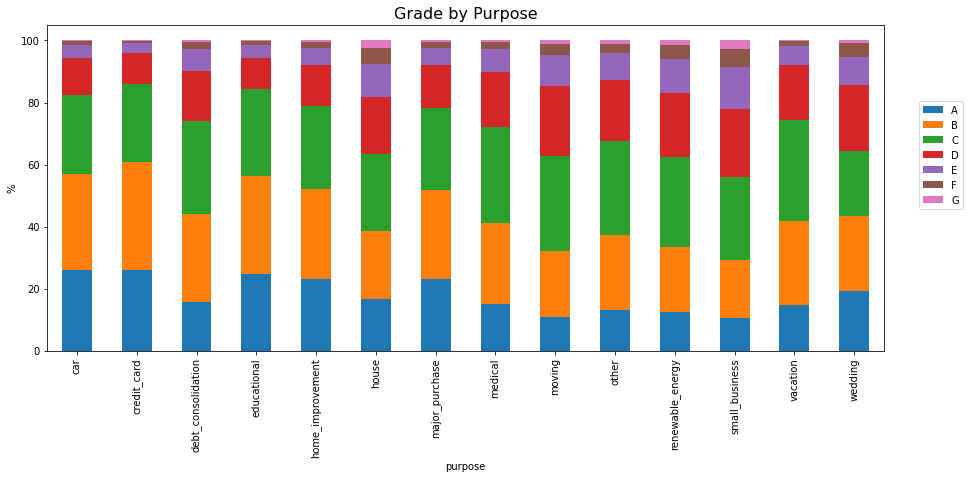

In [89]:
# purposes of loan and loan grades
pd.crosstab(df['purpose'], df['grade'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Grade by Purpose', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')

Overall, A, B , C are the most popular loan grade and it can be seen that there is no special relationship between loan purposes and assigned grades since in each purpose, the percentage of loan grades are not significantly differently from each other.

### Interest rate

#### Interest vs sub-grade 

Each grade have coresponding interest to Grade which is mentrion at LendingClub website:

(https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees. Last access 15.02.2022)

Text(0.5, 1.0, 'Interest rate distribution by Grade')

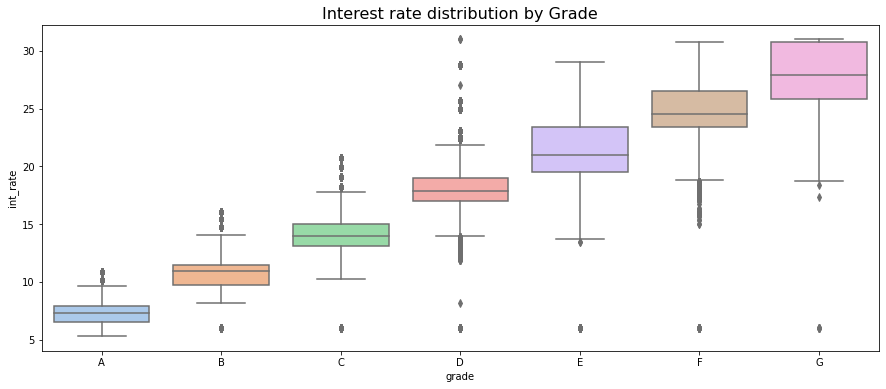

In [92]:
# plot the distribution of interest rate in each loan grade
sns.boxplot(x='grade', y='int_rate', data=df.sort_values('grade'), palette="pastel")
plt.title("Interest rate distribution by Grade", fontsize=16)

* Grades given the highest interest rates are G, F and E (in descending order), respectively with mean at 22%, 24%, and 27%. These loan grades show higher levels of risk than the rest of the loans therefore higher interest rates are assigned to them.
* Groups of grades with lowest interest rate are A, B, C (in descending order), respectively with mean at 7%, 11% and 15%. 
* There is no interest rate below 5% because LendingClub set the base rate for every loan at 5.05%. 

(Source: Rate Information. Lendingclub. https://www.lendingclub.com/foliofn/rateDetail.action. Last access 15.02.2022)

### Pearson correlation matrix

In [93]:
# Create Pearson correlation with absolute values
corr_table = df.corr().abs()

In [94]:
# drop_duplicates() may drop all correlation with a variables itself except the fisrt duplicate (loan_amount), we will check the heat map later
# filter out the pair of features which have a correlation value larger than 0.7
corr_table[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt                       loan_amnt                                     1.000000
fico_range_low                  fico_range_high                               1.000000
loan_amnt                       funded_amnt                                   0.999700
total_pymnt_inv                 total_pymnt                                   0.999518
funded_amnt_inv                 funded_amnt                                   0.999380
                                loan_amnt                                     0.999018
open_acc                        num_sats                                      0.998878
num_rev_tl_bal_gt_0             num_actv_rev_tl                               0.982952
collection_recovery_fee         recoveries                                    0.979501
tot_hi_cred_lim                 tot_cur_bal                                   0.974177
sub_grade                       int_rate                                      0.973215
total_pymnt                     total_rec_p

It can be seen that there are many pairs of variables have correlation of 1 or nearly 1. Some of the variables appeared in the list should be remove to make sure that the algorithms have less struggles while training the data and avoid dilute information.

## Conclusion of EDA

In this part of Exploratory data analysis, there are some charateristics of LendingClub applicants canbe noticed:

* Overall, most of the people come to LendingClub with a good profile (good average FICO scores and no public records of bankruptcies). They need loans because of their financial reasons (Debt consolidation and credit card).

* Most people have a shorter loan term (36 months, compared to 60 months) and do not enroll into the hardship plan, but the percentage of people who are Charged Off and default accounts for nearly one third of the data sample.

* Checking bivariance relationship cannot show that the features such as annual income, verified status, house ownership, credit line, etc. have a specific effect on Charged Off, Default or Late status.

* People with lower interest rate and lower loan amount likely to pay off loans successfully.

## Data preparation

### Cleaning columns
Based on the exploratory data analysis part, there are columns should be removed with below reasons.

#### Reason 1: Unrelated information
Columns have less usefull information related to the purpose of this project

In [95]:
df.filter(items=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths']).head()

,url,id,zip_code,title,emp_title,inq_fi,mths_since_recent_inq,inq_last_6mths
0,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,1077501,860xx,Computer,NaN,NaN,NaN,1.0
1,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,1077430,309xx,bike,Ryder,NaN,NaN,5.0
2,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,1077175,606xx,real estate business,NaN,NaN,NaN,2.0
3,https://lendingclub.com/browse/loanDetail.action?loan_id=1076863,1076863,917xx,personel,AIR RESOURCES BOARD,NaN,NaN,1.0
4,https://lendingclub.com/browse/loanDetail.action?loan_id=1075358,1075358,972xx,Personal,University Medical Group,NaN,NaN,0.0


* id and url columns contains unique ID or url for each customers, does not have other meaning
* inq_fi: Number of personal finance inquiries by LendingClub
* mths_since_recent_inq: Months since most recent inquiry
* inq_last_6mths: The number of inquiries in past 6 months. 
* A credit inquiry is a request put up by a financial institution or firm for the credit report information of an individual from a credit reporting bureau, so it not related to characteristics of loan or behavioral payments.

Information which only served the purpose of administration like this should be removed

In [96]:
# Drop above columns
df.drop(columns=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths'], inplace=True)

#### Reason 2: Missing values

##### Columns have too many missing values

In [97]:
# check and calculate the percentage of null values out of the total values counted in each column
null_values = df.isnull().sum()
# len(df.index) is to count the total number of values in a columns supposed to have
percent_nullvalues = null_values/len(df.index)*100 

In [98]:
# sort the percentage of missing values from high to low
percent_nullvalues.sort_values(ascending=False, axis=0)

next_pymnt_d                                  100.000000
hardship_loan_status                           99.318186
deferral_term                                  99.317595
hardship_length                                99.317595
hardship_type                                  99.317595
hardship_status                                99.317595
hardship_start_date                            99.317595
payment_plan_start_date                        99.317595
hardship_end_date                              99.317595
hardship_dpd                                   99.317595
hardship_reason                                99.317541
orig_projected_additional_accrued_interest     98.967227
hardship_amount                                98.814781
hardship_payoff_balance_amount                 98.814781
hardship_last_payment_amount                   98.814781
sec_app_revol_util                             96.900983
revol_bal_joint                                96.848358
sec_app_fico_range_high        

A feature cannot bring much value to the prediction when it has too many null values.
Therefore, a threshold of 50% is chosen to remove all columns which have the number of missing values larger or equal to 50% of the total values in each column. 

In [99]:
# remove columns with a condition that more than 50% of the values in that column is null
df.dropna(axis=1, thresh=(1-0.5)*len(df.index), inplace=True)

#### Reason 3: Uninformative for classification
Columns bring little information for classification

Text(0.5, 0.98, 'Distribution of classes in each feature')

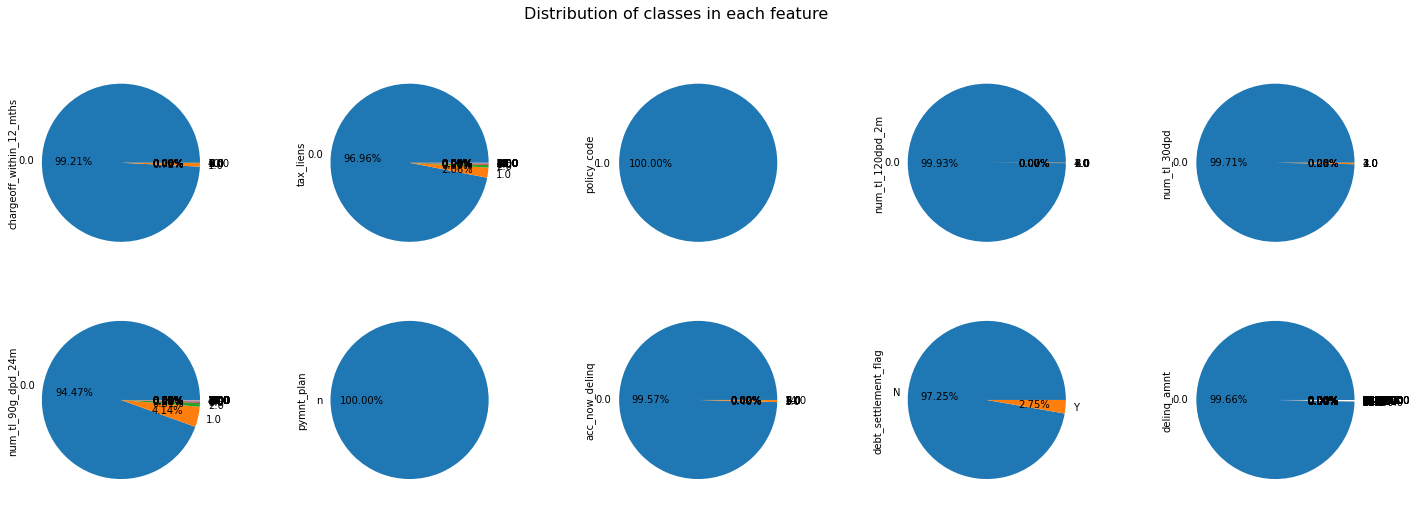

In [100]:
fig, axs = plt.subplots(2, 5, figsize=(25, 8))
# 1st row
df['chargeoff_within_12_mths'].value_counts().plot.pie(ax=axs[0,0], autopct='%.2f%%')
df['tax_liens'].value_counts().plot.pie(ax=axs[0,1],autopct='%.2f%%')
df['policy_code'].value_counts().plot.pie(ax=axs[0,2],autopct='%.2f%%')
df['num_tl_120dpd_2m'].value_counts().plot.pie(ax=axs[0,3],autopct='%.2f%%')
df['num_tl_30dpd'].value_counts().plot.pie(ax=axs[0,4],autopct='%.2f%%')
# 2ns row
df['num_tl_90g_dpd_24m'].value_counts().plot.pie(ax=axs[1,0],autopct='%.2f%%')
df['pymnt_plan'].value_counts().plot.pie(ax=axs[1,1],autopct='%.2f%%')
df['acc_now_delinq'].value_counts().plot.pie(ax=axs[1,2],autopct='%.2f%%')
df['debt_settlement_flag'].value_counts().plot.pie(ax=axs[1,3],autopct='%.2f%%')
df['delinq_amnt'].value_counts().plot.pie(ax=axs[1,4], autopct='%.2f%%')
# set title
fig.suptitle('Distribution of classes in each feature', fontsize=16)

* The pie graphs show feature contains only one value/label only (account for nearly 100%). For example, num_tl_30dpd show that 99.89% of applicants have zero accounts currently 30 days past due.
* For categorial variables that contain only one type of class or numerical variables that contain only one type of numerical data for all the applicants; The model will not use them for classification, especially for the tree-based model like XGBoost. 

In [101]:
# date and time
df_date = df.filter(items=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'])
df_date.head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2011,Jan-1985,Jan-2015,May-2020
1,Dec-2011,Apr-1999,Apr-2013,Oct-2016
2,Dec-2011,Nov-2001,Jun-2014,Jun-2017
3,Dec-2011,Feb-1996,Jan-2015,Apr-2016
4,Dec-2011,Jan-1996,Jan-2017,Apr-2018


* All the columns containing information about date and time are also removed since there is no relevant data or benchmark of time to do a further examination to understand these values

Other features are mentioned below:
* initial_list_status: identifies whether a loan was initially listed in the whole (W) or fractional (F) market, bringing information from the view of investors, so it is not useful in predicting if a borrower can pay back the money to an investor or not.

* To avoid diluting the information, between grade and sub_grade, we choose to keep sub_grade only

In [102]:
df.drop(columns=['initial_list_status', 'grade', 
                 'chargeoff_within_12_mths', 'tax_liens', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                 'num_tl_90g_dpd_24m', 'pymnt_plan', 'acc_now_delinq', 'debt_settlement_flag', 'delinq_amnt', 
                 'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d',
                ], inplace=True)

#### Reason 4: Collected data after a loan is granted

There are also columns presenting what happens after a loan is granted. They should be dropped to avoid the overfitting model. 
They are the information related to recoveries, installments, or hardship. For example, hardship_flag should be removed because it is applied as a last resort for a borrower when he/she is struggling to pay monthly installments after getting the loan. 

In [103]:
df.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                 'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                 'total_il_high_credit_limit', 'hardship_flag', 'installment', 
                 'revol_util','collections_12_mths_ex_med'],
                inplace=True)

#### Reason 5: High correlation - Based on Pearson correlation matrix

In [104]:
# After droping some columns, we create a new correlation table for the rest of features
cr = df.corr().abs()

# filter out the pair of features with correlation score larger than 0.7
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt             loan_amnt               1.000000
fico_range_low        fico_range_high         1.000000
num_sats              open_acc                0.998878
num_actv_rev_tl       num_rev_tl_bal_gt_0     0.982952
tot_hi_cred_lim       tot_cur_bal             0.974177
sub_grade             int_rate                0.973215
total_bal_ex_mort     total_bal_il            0.902185
bc_util               percent_bc_gt_75        0.846975
total_bc_limit        bc_open_to_buy          0.844801
open_rv_24m           acc_open_past_24mths    0.844315
num_bc_tl             num_rev_accts           0.839571
num_tl_op_past_12m    open_rv_12m             0.838488
open_acc              num_op_rev_tl           0.835359
num_sats              num_op_rev_tl           0.834540
avg_cur_bal           tot_cur_bal             0.830157
num_bc_sats           num_actv_bc_tl          0.829640
num_actv_rev_tl       num_actv_bc_tl          0.815887
num_actv_bc_tl        num_rev_tl_bal_gt_0     0.809037
total_rev_

In [105]:
# drop features based on the results above
df.drop(columns=['num_sats','num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
                'bc_open_to_buy', 'percent_bc_gt_75', 'total_bal_ex_mort',
                'num_rev_accts', 'num_actv_bc_tl', 'num_op_rev_tl', 
                'avg_cur_bal', 'num_tl_op_past_12m', 'open_rv_24m', 'open_il_24m',
                'pub_rec_bankruptcies', 'total_rev_hi_lim', 'num_bc_sats',
                'total_acc'], inplace=True)

In [106]:
# check again if any correlation coefficients >0.7
cr = df.corr().abs()
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt       loan_amnt          1.000000
fico_range_low  fico_range_high    1.000000
sub_grade       int_rate           0.973215
loan_amnt       int_rate                NaN
dtype: float64

<AxesSubplot:>

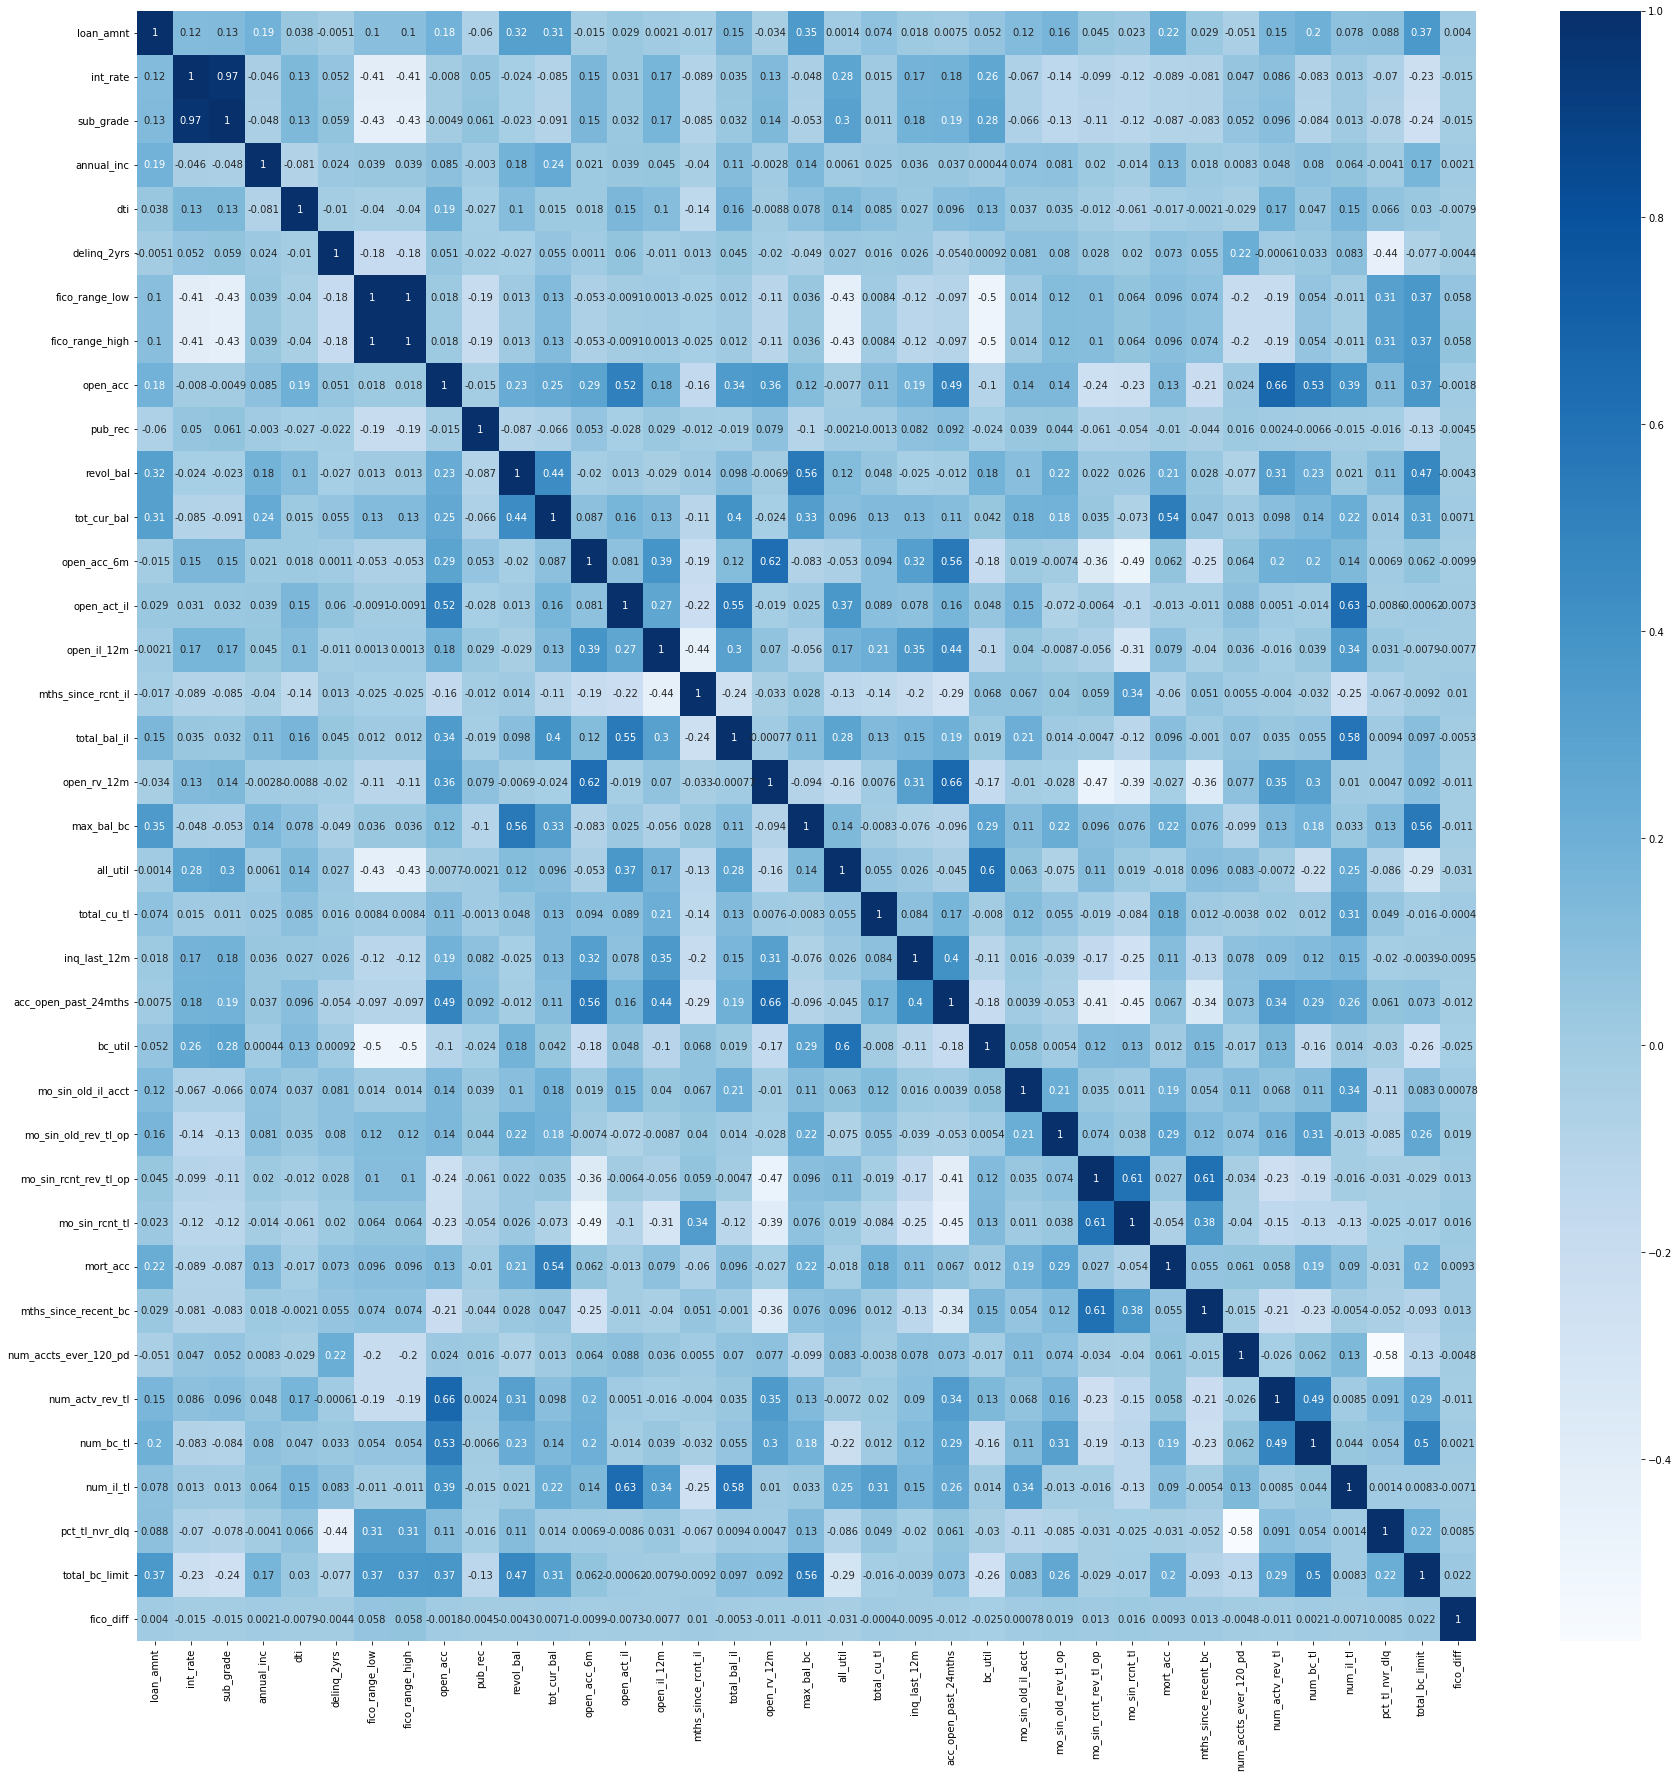

In [107]:
# final check with correlation matrix
plt.figure(figsize=(30,30))        
sns.heatmap(df.corr(), annot=True, cmap="Blues")

* The correlation matrix present the correlation among numerical features. It can be seen that all the pairs with correlation bigger than 0.7 are dropped out. 
* Note that since we are using Pearson correlation, correlation coefficients close to 0 do not mean that there is no relationship between two features. There may be a nonlinear relationship. 

### Cleaning rows

In this part duplicated values will be checked as well as all the rows containing null values will be deleted. For the XGBoost model, it may be unnecessary to clean all the rows with null values since the model itself can set these null values to 0, but for the Logistic model, it can not train the data containing NaN values. We try to obtain a data sample that both models can be trained on.

In [109]:
# check duplicated values
df.loc[df.duplicated(keep='first')]

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_tl,num_il_tl,pct_tl_nvr_dlq,total_bc_limit,fico_diff


Conclusion: There is no rows which are exactly duplicated.

In [110]:
# drop rows with missing values
df.dropna(inplace=True)

# check missing value in rows
df.isnull().sum().sort_values()

loan_amnt                0
total_bal_il             0
open_rv_12m              0
max_bal_bc               0
all_util                 0
total_cu_tl              0
inq_last_12m             0
acc_open_past_24mths     0
bc_util                  0
mo_sin_old_il_acct       0
mo_sin_old_rev_tl_op     0
mo_sin_rcnt_rev_tl_op    0
mo_sin_rcnt_tl           0
mort_acc                 0
mths_since_recent_bc     0
num_accts_ever_120_pd    0
num_actv_rev_tl          0
num_bc_tl                0
num_il_tl                0
pct_tl_nvr_dlq           0
mths_since_rcnt_il       0
total_bc_limit           0
open_il_12m              0
open_acc_6m              0
term                     0
int_rate                 0
sub_grade                0
emp_length               0
home_ownership           0
annual_inc               0
verification_status      0
loan_status              0
purpose                  0
addr_state               0
dti                      0
delinq_2yrs              0
fico_range_low           0
f

In [111]:
# check the final dimension of the dataset after cleaning
df.shape

(903816, 45)

After cleaning the dimension of the dataset are 903816 rows and 45 columns. The number of columns decrease significantly, compared to the initial of 141 columns.

In [112]:
df.to_csv('final_df.csv', index=False)

### Convert data types

XGBoost model only allows for int, float, or boolean data types, so we check and convert where necessary.

In [3]:
# check the data type for each feature
df.dtypes.sort_values()

loan_amnt                float64
total_bal_il             float64
open_rv_12m              float64
max_bal_bc               float64
all_util                 float64
total_cu_tl              float64
inq_last_12m             float64
acc_open_past_24mths     float64
bc_util                  float64
mo_sin_old_il_acct       float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mo_sin_rcnt_tl           float64
mort_acc                 float64
mths_since_recent_bc     float64
num_accts_ever_120_pd    float64
num_actv_rev_tl          float64
num_bc_tl                float64
num_il_tl                float64
pct_tl_nvr_dlq           float64
mths_since_rcnt_il       float64
total_bc_limit           float64
open_il_12m              float64
open_acc_6m              float64
int_rate                 float64
sub_grade                float64
annual_inc               float64
open_act_il              float64
dti                      float64
delinq_2yrs              float64
fico_diff 

In [4]:
df[['purpose', 'loan_status', 'verification_status', 'home_ownership', 'emp_length', 'application_type', 'term', 'addr_state']]

,purpose,loan_status,verification_status,home_ownership,emp_length,application_type,term,addr_state
0,debt_consolidation,Fully Paid,Source Verified,OWN,10+ years,Individual,36 months,CA
1,debt_consolidation,Fully Paid,Not Verified,MORTGAGE,3 years,Individual,36 months,OR
2,debt_consolidation,Fully Paid,Not Verified,RENT,5 years,Individual,36 months,TX
3,medical,Fully Paid,Source Verified,MORTGAGE,4 years,Individual,36 months,TX
4,home_improvement,Charged Off,Verified,OWN,10+ years,Individual,60 months,WI
...,...,...,...,...,...,...,...,...
903811,other,Charged Off,Source Verified,RENT,< 1 year,Individual,60 months,CO
903812,debt_consolidation,Fully Paid,Source Verified,MORTGAGE,10+ years,Individual,36 months,PA
903813,debt_consolidation,Charged Off,Not Verified,RENT,8 years,Individual,36 months,VA
903814,credit_card,Fully Paid,Source Verified,RENT,5 years,Individual,36 months,NY


We treat 'term' and 'emp_length' as categorical model for the XGBoost model. For 'term', the reason is obvious because there are only 2 types in provided from the company. For 'emp_length', the classes of 'less than 1 year' or 'more than 10 years' is hard to be precise if they are converted to numeric type.

##### Setting dummies

There are many methods but here get_dummies is used to convert categrical variables because it is fast and simple.

In [53]:
discrete_columns = list(df_xgb.select_dtypes(include=['int', 'uint8']).columns)
len(discrete_columns)

88

In [4]:
# One-hot encoding with Pandas: setting the dummies
df_xgb = pd.get_dummies(df, columns=['application_type',
                                    'addr_state',
                                    'purpose',
                                    'verification_status',
                                    'home_ownership',
                                    'emp_length',
                                    'term'])
# reset index
df_xgb= df_xgb.reset_index(drop=True)
# check the new data created
df_xgb.head().transpose()

,0,1,2,3,4
loan_amnt,12000.0,10000.0,12800.0,15000.0,40000.0
int_rate,7.97,9.44,13.59,13.59,7.97
sub_grade,4.0,5.0,11.0,11.0,4.0
annual_inc,42000.0,55000.0,90000.0,180000.0,200000.0
loan_status,Fully Paid,Fully Paid,Fully Paid,Fully Paid,Charged Off
dti,27.74,18.79,22.63,38.07,14.37
delinq_2yrs,0.0,0.0,0.0,0.0,0.0
fico_range_low,715.0,695.0,660.0,680.0,760.0
fico_range_high,719.0,699.0,664.0,684.0,764.0
open_acc,9.0,7.0,10.0,24.0,25.0


* The original columns of 'application_type','addr_state','purpose','verification_status','home_ownership','emp_length' and 'term' are disappear

##### Handling Loan status

In [5]:
# check the number of each label inloan_status 
df_xgb.loan_status.value_counts()

Fully Paid     722580
Charged Off    181236
Name: loan_status, dtype: int64

In [118]:
722580/181236

3.9869562338608224

It can be seen that the number of Fully Paid is 4 times higher than the number of Charged Off class.

In [5]:
# Convert classes in loan_status to positive class (1) and negative class (0)
df_xgb = df_xgb.replace({"loan_status":{ "Fully Paid": 0, "Charged Off": 1}})

### Set up independent and dependent variables

The main purpose here is predict status of borrowers. We denote:
* x as predictors  
* y as the response variable of the model

Obviously, x contains all features in the dataset except loan_status.

In [6]:
df_xgb_sample = df_xgb.sample(100000, random_state=2023)
df_xgb_sample.loan_status.value_counts()

0    79884
1    20116
Name: loan_status, dtype: int64

In [209]:
df_xgb_sample.drop(['home_ownership_NONE', 'purpose_educational', 'purpose_wedding'], axis=1, inplace=True)

In [9]:
# Split data for x
x = df_xgb_sample.drop(columns=['loan_status'], axis=1).copy()

In [211]:
#x = x.convert_dtypes()
x.shape

(100000, 121)

In [10]:
x_converted = x.convert_dtypes()
cols_to_int = x_converted[x.columns[x.dtypes=='float64']]\
            .columns[
                    x_converted[
                                x.columns[x.dtypes=='float64']
                                ].dtypes=='Int64'
                    ]
cols_to_int

Index(['loan_amnt', 'sub_grade', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'mths_since_rcnt_il',
       'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util', 'total_cu_tl',
       'inq_last_12m', 'acc_open_past_24mths', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'total_bc_limit',
       'fico_diff'],
      dtype='object')

Now the predictor data have 903816 rows and 124 columns

In [11]:
# assign data for y
y = df_xgb_sample['loan_status']

#Convert y to integer type for further calculation
y = y.astype('int')
y.shape

(100000,)

# Metrics to estimate generation quality

## main metric

In [30]:
def make_df_discrimination(x_gen, x_true, imblearn=True):
    if imblearn:
        df_discrimination = x_gen.copy()
        df_discrimination['real'] = 1
        mask = df_discrimination.index >= len(x_true)
        df_discrimination.loc[mask, 'real'] = 0
    else:
        x_gen['real'] = 0
        x_true['real'] = 1
        df_discrimination = pd.concat([x_gen, x_true]).reset_index(drop=True)
    return df_discrimination

In [35]:
def calc_f1(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    print("Test F1 = %.4f" % f1)
    return f1

## control metrics

In [107]:
rvs1 = sorted(stats.expon.rvs(loc=5, scale=10, size=100, random_state=2021))
rvs2 = sorted(stats.norm.rvs(loc=5, scale=10, size=100, random_state=2022))
p_value = stats.ttest_ind(rvs1, rvs2, equal_var=False)[1]
p_value

4.5086300052621114e-13

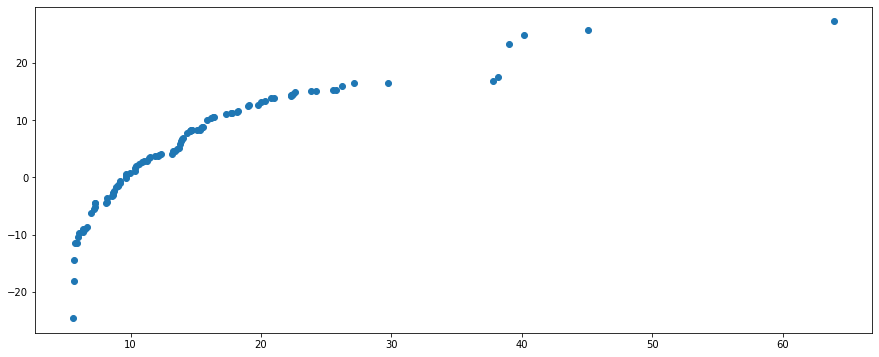

In [104]:
plt.scatter(rvs1, rvs2)

In [123]:
stats.ttest_ind(x_smote[:len(x)-1][x_smote.columns[0]],
                x_smote[len(x):][x_smote.columns[0]], equal_var=False)

Ttest_indResult(statistic=-35.108818675094405, pvalue=8.797853302646522e-269)

In [77]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(len(names)):
        plt.subplot(2, 2, i+1)
        plt.hist(X1.iloc[:, i], bins=bins, alpha=0.5, label=label1, color='C0', density=True)
        plt.hist(X2.iloc[:, i], bins=bins, alpha=0.5, label=label2, color='C1', density=True)
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
        plt.grid()
    plt.tight_layout()

In [29]:
plot_hists(x_smote[x_smote.columns[:4]][:len(x)-1],
          x_smote[x_smote.columns[:4]][len(x):],
          list(x_smote.columns[:4]),
          'real',
          'generated',
          bins=20)

NameError: name 'x_smote' is not defined

In [215]:
numerical_failed_counter = 0
binary_failed_counter = 0
invalid_binary_columns, invalid_numerical_columns = [], []
binary_results, numerical_results = [], []

binary_cols = x_smote.columns[x_smote.isin([0,1]).all()]

for col in x_smote.columns:
    if col in binary_cols:
        true = x_smote[:len(x)][col]
        gen = x_smote[len(x):][col]
        true_likelihood = np.log(true.mean())*true.sum() + np.log(1-true.mean())*(len(true)-true.sum())
        gen_likelihood = np.log(gen.mean())*gen.sum() + np.log(1-gen.mean())*(len(gen)-gen.sum())
        likelihood_ratio = (-2*(min(true_likelihood, gen_likelihood)-max(true_likelihood, gen_likelihood)))
        # print(likelihood_ratio)
        result = 1-ss.chi2.cdf(likelihood_ratio, 1)
        binary_results.append(result)
        #print('binary -', col, result)
        if result<0.01:
            binary_failed_counter += 1
            invalid_binary_columns.append(col)
    else:
        true, bins = pd.qcut(x_smote[:len(x)][col], min(50, x[col].nunique()), retbins=True, labels=False, duplicates='drop')
        gen = pd.cut(x_smote[len(x):][col], bins=bins, labels=False, include_lowest=True)
        result = stats.ttest_ind(true, gen, equal_var=False)[1]
        numerical_results.append(result)
        #print('numerical -', col, result)
        if result<0.01:
            numerical_failed_counter += 1
            invalid_numerical_columns.append(col)
            
print_cols = (binary_failed_counter/len(binary_cols)) < 0.1
print("median binary p-value =", np.nanmedian(binary_results))
print("invalid binary ratio = %.4f" % (binary_failed_counter/len(binary_cols)))
if print_cols:
    print('invalid binary columns', invalid_binary_columns)

print_cols = (numerical_failed_counter/(len(x_smote.columns)-len(binary_cols))) < 0.1
print("median numerical p-value =", np.nanmedian(numerical_results))
print("invalid numerical ratio = %.4f" % (numerical_failed_counter/(len(x_smote.columns)-len(binary_cols))))
if print_cols:
    print('invalid numerical columns', invalid_numerical_columns)

print("invalid overall ratio = %.4f" % ((binary_failed_counter+numerical_failed_counter)/len(x_smote.columns)))

median binary p-value = 0.0
invalid binary ratio = 0.8161
median numerical p-value = 1.1052972320453297e-129
invalid numerical ratio = 0.9730
invalid overall ratio = 0.8629


divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


In [228]:
true_corr = x_smote[:len(x)].corr().fillna(0)
gen_corr = x_smote[len(x):].corr().fillna(0)

In [236]:
1 - np.trace(true_corr @ gen_corr) \
/ (np.linalg.norm(true_corr) * np.linalg.norm(gen_corr))

0.058935035805075975

In [263]:
correlation_relation = np.abs(true_corr-gen_corr)
float(correlation_relation.describe().max(axis=1)['75%'])

0.03747508514577321

In [76]:
def calc_control_metrics(x_gen, x_true,
                         bins_for_numerical=50,
                         border_to_print_cols=0.1):
    # calc tests for difference, want highest possible p-values
    numerical_failed_counter = 0
    binary_failed_counter = 0
    invalid_binary_columns, invalid_numerical_columns = [], []
    binary_results, numerical_results = [], []

    binary_cols = x_true.columns[x_true.isin([0,1]).all()]

    for col in x_gen.columns:
        if col in binary_cols:
            true = x_true[col]
            gen = x_gen[col]
            true_likelihood = np.log(true.mean())*true.sum() + np.log(1-true.mean())*(len(true)-true.sum())
            gen_likelihood = np.log(gen.mean())*gen.sum() + np.log(1-gen.mean())*(len(gen)-gen.sum())
            likelihood_ratio = (-2*(min(true_likelihood, gen_likelihood)-max(true_likelihood, gen_likelihood)))
            # print(likelihood_ratio)
            result = 1-stats.chi2.cdf(likelihood_ratio, 1)
            binary_results.append(result)
            #print('binary -', col, result)
            if result<0.01:
                binary_failed_counter += 1
                invalid_binary_columns.append(col)
        else:
            true, bins = pd.qcut(x_true[col], min(bins_for_numerical, x_true[col].nunique()), retbins=True, labels=False, duplicates='drop')
            gen = pd.cut(x_gen[col], bins=bins, labels=False, include_lowest=True)
            result = stats.ttest_ind(true, gen, equal_var=False)[1]
            numerical_results.append(result)
            #print('numerical -', col, result)
            if result<0.01:
                numerical_failed_counter += 1
                invalid_numerical_columns.append(col)

    print_cols = (binary_failed_counter/len(binary_cols)) < border_to_print_cols
    # want higher median
    print("median binary p-value =", np.nanmedian(binary_results))
    # want lower ratio
    print("invalid binary ratio = %.4f" % (binary_failed_counter/len(binary_cols)))
    if print_cols:
        print('invalid binary columns', invalid_binary_columns)

    print_cols = (numerical_failed_counter/(len(x_gen.columns)-len(binary_cols))) < border_to_print_cols
    # want higher median
    print("median numerical p-value =", np.nanmedian(numerical_results))
    # want lower ratio
    print("invalid numerical ratio = %.4f" % (numerical_failed_counter/(len(x_gen.columns)-len(binary_cols))))
    if print_cols:
        print('invalid numerical columns', invalid_numerical_columns)
    invalid_overall_ratio = (binary_failed_counter+numerical_failed_counter)/len(x_gen.columns)
    print("invalid overall ratio = %.4f" % (invalid_overall_ratio))
    
    true_corr = x_true.corr().fillna(0)
    gen_corr = x_gen.corr().fillna(0)
    
    # want lower distance
    corr_distance = 1 - np.trace(true_corr @ gen_corr) \
        / (np.linalg.norm(true_corr) * np.linalg.norm(gen_corr))
    print('Correlation Matrix Distance = %.4f' % corr_distance)
    
    # want lower percentile
    correlation_relation = np.abs(true_corr-gen_corr)
    max_q75_corr = float(correlation_relation.describe().max(axis=1)['75%'])
    print('quantile 75 of maximum diff between pairwise correlations by columns = %.4f' % max_q75_corr)
    
    return {'invalid_overall_ratio' : invalid_overall_ratio,
            'corr_distance' : corr_distance,
            'max_q75_corr' : max_q75_corr}

## summary function

In [26]:
def calc_metrics(x_gen, y_true, y_pred,
                 x_true):
    control_dict = calc_control_metrics(x_gen, x_true)
    key_metric = calc_f1(y_true, y_pred)
    control_dict['f1'] = key_metric
    return control_dict

# Oversampling methods

In [9]:
def make_int_columns(df, cols_to_int=cols_to_int):
    for col in list(cols_to_int):
        df[col] = df[col].astype(int)

NameError: name 'cols_to_int' is not defined

In [10]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, ADASYN
from catboost import Pool

In [281]:
df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])

,loan_amnt,int_rate,sub_grade,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,pub_rec,...,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,term_ 36 months,term_ 60 months
320718,25000.0,13.56,10.0,120000.0,24.04,0.0,715.0,719.0,16.0,0.0,...,0,1,0,0,0,0,0,0,0,1
417916,14275.0,18.99,18.0,60000.0,22.28,1.0,675.0,679.0,9.0,2.0,...,0,0,0,1,0,0,0,0,1,0
720869,3000.0,14.99,13.0,20764.0,14.05,1.0,675.0,679.0,6.0,0.0,...,0,1,0,0,0,0,0,0,1,0
265486,20000.0,24.37,21.0,34320.0,24.62,1.0,700.0,704.0,9.0,0.0,...,0,0,1,0,0,0,0,0,0,1
61310,15000.0,12.62,10.0,60000.0,27.58,0.0,700.0,704.0,16.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740430,3200.0,13.49,11.0,91500.0,26.11,0.0,680.0,684.0,14.0,0.0,...,0,0,0,0,0,0,0,0,1,0
101119,12000.0,24.85,22.0,63000.0,28.25,0.0,740.0,744.0,29.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3364,13000.0,25.82,23.0,35000.0,3.57,0.0,810.0,814.0,6.0,0.0,...,0,0,0,0,0,0,0,1,0,1
376189,10000.0,11.99,10.0,40000.0,9.12,0.0,665.0,669.0,8.0,1.0,...,0,0,0,0,0,0,0,1,1,0


In [285]:
k_neighbors = [3, 5, 10, 20, 50, 100]
results = {key:0 for key in k_neighbors}

for n in k_neighbors:
    print('k_neighbors =', n)
    
    smote = SMOTE(random_state=2023, k_neighbors=n)
    x_smote, y_smote = smote.fit_resample(x, y)
    make_int_columns(x_smote)
    
    x_gen = x_smote[len(x):]
    x_true = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])
    metrics_dict = calc_control_metrics(x_gen, x_true)
    df_discrimination = make_df_discrimination(x_smote, x_true)
    #display(df_discrimination.loc[df_discrimination.real==1].head())
    #display(df_discrimination.loc[df_discrimination.real==0].head())
    x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                            df_discrimination['real'], test_size=0.3,
                                                        random_state=2023, stratify=df_discrimination['real'])
    discriminator = cbclf(iterations=200, verbose=False, random_seed=2023)
    discriminator.fit(Pool(x_disc_train, y_disc_train),
                      eval_set=Pool(x_disc_test, y_disc_test))
    y_disc_pred = discriminator.predict(Pool(x_disc_test, y_disc_test))
    results[n] = calc_f1(y_disc_test, y_disc_pred)

print(results)

k_neighbors = 3


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8333
median numerical p-value = 8.288640043597979e-10
invalid numerical ratio = 0.7568
invalid overall ratio = 0.8099
Correlation Matrix Distance = 0.0643
quantile 75 of maximum diff between pairwise correlations by columns = 0.0400


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Test F1 = 0.0000
k_neighbors = 5


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8095
median numerical p-value = 1.0966005579361833e-09
invalid numerical ratio = 0.7297
invalid overall ratio = 0.7851
Correlation Matrix Distance = 0.0698
quantile 75 of maximum diff between pairwise correlations by columns = 0.0383
Test F1 = 0.0003
k_neighbors = 10


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8452
median numerical p-value = 1.233894877749651e-09
invalid numerical ratio = 0.7297
invalid overall ratio = 0.8099
Correlation Matrix Distance = 0.0615
quantile 75 of maximum diff between pairwise correlations by columns = 0.0395
Test F1 = 0.0003
k_neighbors = 20


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8214
median numerical p-value = 1.601623858586125e-08
invalid numerical ratio = 0.7568
invalid overall ratio = 0.8017
Correlation Matrix Distance = 0.0679
quantile 75 of maximum diff between pairwise correlations by columns = 0.0378
Test F1 = 0.0007
k_neighbors = 50


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8333
median numerical p-value = 1.9972783960202574e-08
invalid numerical ratio = 0.6757
invalid overall ratio = 0.7851
Correlation Matrix Distance = 0.0653
quantile 75 of maximum diff between pairwise correlations by columns = 0.0386
Test F1 = 0.0013
k_neighbors = 100


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8690
median numerical p-value = 1.3992864370625963e-09
invalid numerical ratio = 0.7568
invalid overall ratio = 0.8347
Correlation Matrix Distance = 0.0569
quantile 75 of maximum diff between pairwise correlations by columns = 0.0374
Test F1 = 0.0007
{3: 0.0, 5: 0.0003312355084465055, 10: 0.00033107101473266014, 20: 0.000662361318099023, 50: 0.001322970067802216, 100: 0.0006619228859837829}


### BorderlineSMOTE

In [286]:
k_neighbors = [3, 5, 10, 20, 50, 100]
results = {key:0 for key in k_neighbors}

for n in k_neighbors:
    print('k_neighbors =', n)
    
    smote = BorderlineSMOTE(random_state=2023, k_neighbors=n)
    x_smote, y_smote = smote.fit_resample(x, y)
    make_int_columns(x_smote)
    
    x_gen = x_smote[len(x):]
    x_true = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])
    metrics_dict = calc_control_metrics(x_gen, x_true)
    df_discrimination = make_df_discrimination(x_smote, x_true)

    x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                            df_discrimination['real'], test_size=0.3,
                                                        random_state=2023, stratify=df_discrimination['real'])
    discriminator = cbclf(iterations=200, verbose=False, random_seed=2023)
    discriminator.fit(Pool(x_disc_train, y_disc_train),
                      eval_set=Pool(x_disc_test, y_disc_test))
    y_disc_pred = discriminator.predict(Pool(x_disc_test, y_disc_test))
    results[n] = calc_f1(y_disc_test, y_disc_pred)

print(results)

k_neighbors = 3


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8214
median numerical p-value = 2.3689818568679158e-08
invalid numerical ratio = 0.7297
invalid overall ratio = 0.7934
Correlation Matrix Distance = 0.0671
quantile 75 of maximum diff between pairwise correlations by columns = 0.0378
Test F1 = 0.0003
k_neighbors = 5


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8214
median numerical p-value = 2.8742657389614316e-07
invalid numerical ratio = 0.7568
invalid overall ratio = 0.8017
Correlation Matrix Distance = 0.0671
quantile 75 of maximum diff between pairwise correlations by columns = 0.0383
Test F1 = 0.0000
k_neighbors = 10


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8333
median numerical p-value = 9.057105228263734e-09
invalid numerical ratio = 0.7297
invalid overall ratio = 0.8017
Correlation Matrix Distance = 0.0642
quantile 75 of maximum diff between pairwise correlations by columns = 0.0378
Test F1 = 0.0000
k_neighbors = 20


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8452
median numerical p-value = 9.229642867307135e-10
invalid numerical ratio = 0.7297
invalid overall ratio = 0.8099
Correlation Matrix Distance = 0.0617
quantile 75 of maximum diff between pairwise correlations by columns = 0.0376
Test F1 = 0.0000
k_neighbors = 50


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8571
median numerical p-value = 5.415927526714468e-09
invalid numerical ratio = 0.7838
invalid overall ratio = 0.8347
Correlation Matrix Distance = 0.0591
quantile 75 of maximum diff between pairwise correlations by columns = 0.0374
Test F1 = 0.0000
k_neighbors = 100


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8571
median numerical p-value = 3.468658559250287e-09
invalid numerical ratio = 0.7297
invalid overall ratio = 0.8182
Correlation Matrix Distance = 0.0596
quantile 75 of maximum diff between pairwise correlations by columns = 0.0375
Test F1 = 0.0000
{3: 0.0003311806590495115, 5: 0.0, 10: 0.0, 20: 0.0, 50: 0.0, 100: 0.0}


### SVMSMOTE

In [288]:
k_neighbors = [3, 5, 10, 20, 50, 100]
results = {key:0 for key in k_neighbors}

for n in k_neighbors:
    print('k_neighbors =', n)
    
    smote = SVMSMOTE(random_state=2023, k_neighbors=n)
    x_smote, y_smote = smote.fit_resample(x, y)
    make_int_columns(x_smote)
    
    x_gen = x_smote[len(x):]
    x_true = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])
    metrics_dict = calc_control_metrics(x_gen, x_true)
    df_discrimination = make_df_discrimination(x_smote, x_true)

    x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                            df_discrimination['real'], test_size=0.3,
                                                        random_state=2023, stratify=df_discrimination['real'])
    discriminator = cbclf(iterations=200, verbose=False, random_seed=2023)
    discriminator.fit(Pool(x_disc_train, y_disc_train),
                      eval_set=Pool(x_disc_test, y_disc_test))
    y_disc_pred = discriminator.predict(Pool(x_disc_test, y_disc_test))
    results[n] = calc_f1(y_disc_test, y_disc_pred)

print(results)

k_neighbors = 3


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9524
median numerical p-value = 4.139273311034614e-19
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6694
Correlation Matrix Distance = 0.0606
quantile 75 of maximum diff between pairwise correlations by columns = 0.0666
Test F1 = 0.0003
k_neighbors = 5


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9524
median numerical p-value = 2.7317563735067425e-19
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6694
Correlation Matrix Distance = 0.0600
quantile 75 of maximum diff between pairwise correlations by columns = 0.0667
Test F1 = 0.0000
k_neighbors = 10


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9524
median numerical p-value = 1.6176109420598956e-18
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6694
Correlation Matrix Distance = 0.0578
quantile 75 of maximum diff between pairwise correlations by columns = 0.0696
Test F1 = 0.0003
k_neighbors = 20


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9643
median numerical p-value = 4.74554857651097e-21
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6777
Correlation Matrix Distance = 0.0596
quantile 75 of maximum diff between pairwise correlations by columns = 0.0695
Test F1 = 0.0000
k_neighbors = 50


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9524
median numerical p-value = 1.0096059349077286e-17
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6694
Correlation Matrix Distance = 0.0618
quantile 75 of maximum diff between pairwise correlations by columns = 0.0749
Test F1 = 0.0000
k_neighbors = 100


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9643
median numerical p-value = 9.743460808480364e-17
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6777
Correlation Matrix Distance = 0.0571
quantile 75 of maximum diff between pairwise correlations by columns = 0.0719
Test F1 = 0.0000
{3: 0.00033101621979476995, 5: 0.0, 10: 0.0003311806590495115, 20: 0.0, 50: 0.0, 100: 0.0}


### ADASYN

In [292]:
k_neighbors = [3, 5, 10, 20, 50, 100]
results = {key:0 for key in k_neighbors}

for n in k_neighbors:
    print('k_neighbors =', n)
    smote = ADASYN(random_state=2023, n_neighbors=n)
    x_smote, y_smote = smote.fit_resample(x, y)
    make_int_columns(x_smote)
    x_gen = x_smote[len(x):]
    x_true = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])
    
    metrics_dict = calc_control_metrics(x_gen, x_true)
    df_discrimination = make_df_discrimination(x_smote, x_true)
    x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                            df_discrimination['real'], test_size=0.3,
                                                        random_state=2023, stratify=df_discrimination['real'])
    discriminator = cbclf(iterations=200, verbose=False, random_seed=2023)
    discriminator.fit(Pool(x_disc_train, y_disc_train),
                      eval_set=Pool(x_disc_test, y_disc_test))
    y_disc_pred = discriminator.predict(Pool(x_disc_test, y_disc_test))
    results[n] = calc_f1(y_disc_test, y_disc_pred)

print(results)

k_neighbors = 3


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8095
median numerical p-value = 8.25124111194784e-09
invalid numerical ratio = 0.8378
invalid overall ratio = 0.8182
Correlation Matrix Distance = 0.0703
quantile 75 of maximum diff between pairwise correlations by columns = 0.0404
Test F1 = 0.0000
k_neighbors = 5


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8095
median numerical p-value = 1.103662918493513e-08
invalid numerical ratio = 0.8378
invalid overall ratio = 0.8182
Correlation Matrix Distance = 0.0703
quantile 75 of maximum diff between pairwise correlations by columns = 0.0380
Test F1 = 0.0007
k_neighbors = 10


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8571
median numerical p-value = 7.581173469961383e-08
invalid numerical ratio = 0.8378
invalid overall ratio = 0.8512
Correlation Matrix Distance = 0.0590
quantile 75 of maximum diff between pairwise correlations by columns = 0.0381
Test F1 = 0.0003
k_neighbors = 20


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8333
median numerical p-value = 6.009207633846104e-09
invalid numerical ratio = 0.8108
invalid overall ratio = 0.8264
Correlation Matrix Distance = 0.0648
quantile 75 of maximum diff between pairwise correlations by columns = 0.0399
Test F1 = 0.0000
k_neighbors = 50


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8690
median numerical p-value = 1.2739532867101748e-09
invalid numerical ratio = 0.8649
invalid overall ratio = 0.8678
Correlation Matrix Distance = 0.0566
quantile 75 of maximum diff between pairwise correlations by columns = 0.0378
Test F1 = 0.0000
k_neighbors = 100


divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.8690
median numerical p-value = 1.0257162648298918e-09
invalid numerical ratio = 0.7838
invalid overall ratio = 0.8430
Correlation Matrix Distance = 0.0572
quantile 75 of maximum diff between pairwise correlations by columns = 0.0383
Test F1 = 0.0000
{3: 0.0, 5: 0.0006621420294653203, 10: 0.0003312903760145768, 20: 0.0, 50: 0.0, 100: 0.0}


* SMOTE - k_neighbors = 50 (ratio=0.68)
* BorderlineSMOTE - 3 (ratio=0.73)
* SVMSMOTE - 3 (ratio=0.03)
* ADASYN - 100 (ratio=0.78)

# Find optimal Discriminator

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
print('k_neighbors =', 3)
    
smote = SVMSMOTE(random_state=2023, k_neighbors=3)
x_smote, y_smote = smote.fit_resample(x, y)
make_int_columns(x_smote)

x_gen = x_smote[len(x):]
x_true = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns=['loan_status'])

k_neighbors = 3


NameError: name 'ss' is not defined

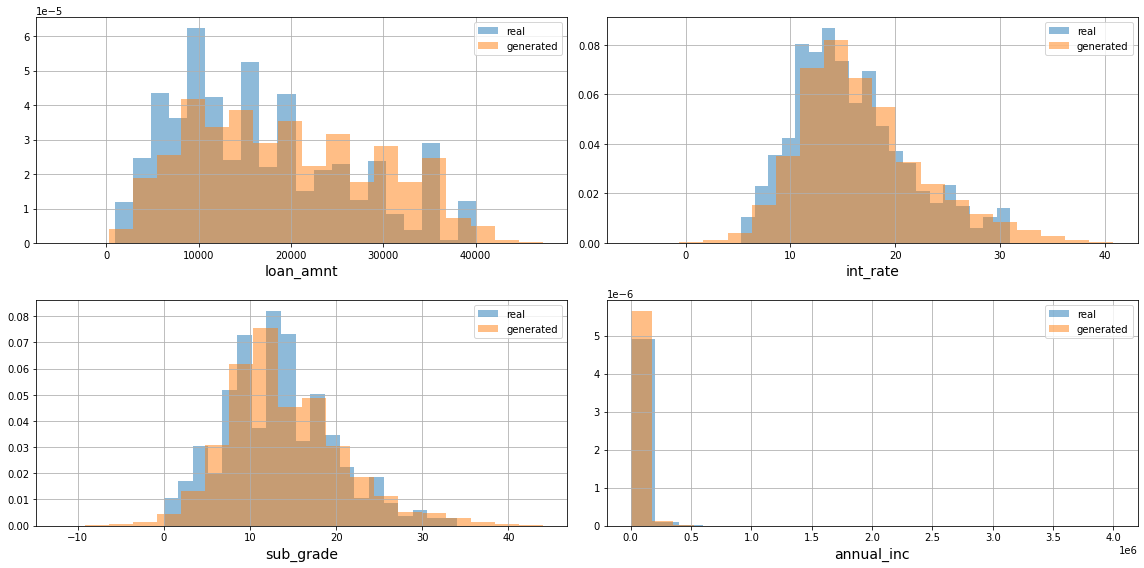

In [30]:
plot_hists(x_true,
          x_gen,
          list(x_smote.columns[:4]),
          'real',
          'generated',
          bins=20)

In [28]:
metrics_dict = calc_control_metrics(x_gen, x_true)
df_discrimination = make_df_discrimination(x_smote, x_true)

x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                        df_discrimination['real'], test_size=0.3,
                                                    random_state=2023, stratify=df_discrimination['real'])
discriminator = cbclf(iterations=200, verbose=False, random_seed=2023)
discriminator.fit(Pool(x_disc_train, y_disc_train),
                  eval_set=Pool(x_disc_test, y_disc_test))
y_disc_pred = discriminator.predict(Pool(x_disc_test, y_disc_test))
calc_f1(y_disc_test, y_disc_pred)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9195
median numerical p-value = 4.139273311034614e-19
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6532
Correlation Matrix Distance = 0.0606
quantile 75 of maximum diff between pairwise correlations by columns = 0.0630
Test F1 = 0.0003


0.00033101621979476995

In [65]:
y_disc_train.value_counts()

0    97756
1    14081
Name: real, dtype: int64

In [66]:
y_disc_test.value_counts()

0    41896
1     6035
Name: real, dtype: int64

In [ ]:
# надо зафиксировать сэмплы из реальных данных для трейна, теста и валидации, чтобы для разных моделей генерации они были одинаковыми


In [26]:
x_gen.to_csv('SVMSMOTE_generated.csv', index=False)

## catboost hp tuning

In [51]:
params = {'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [1, 3],
        'iterations': [100, 200, 300]}
param_list = list(ParameterSampler(param_distributions=params, n_iter=50, random_state=21))
print(param_list[0].keys())

best_f1 = 0
best_params = param_list[0]

with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_disc_train, y=y_disc_train, plot=False,
                   eval_set=[(x_disc_test, y_disc_test)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_disc_test)
        f1_tmp = calc_f1(y_disc_test, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = params_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

dict_keys(['learning_rate', 'l2_leaf_reg', 'iterations', 'depth'])


  2%|▏         | 1/50 [00:02<02:11,  2.68s/it]ogger is already specified. Specify more than one logger at same time is not thread safe.

Test F1 = 0.0000


  4%|▍         | 2/50 [00:15<07:05,  8.86s/it]

Test F1 = 0.0000


  6%|▌         | 3/50 [00:20<05:17,  6.76s/it]

Test F1 = 0.0000


  8%|▊         | 4/50 [00:27<05:18,  6.93s/it]

Test F1 = 0.0000


 10%|█         | 5/50 [00:29<03:52,  5.17s/it]

Test F1 = 0.0000
[11:50:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

 12%|█▏        | 6/50 [00:35<03:58,  5.43s/it]

Test F1 = 0.0000


 14%|█▍        | 7/50 [00:39<03:35,  5.02s/it]

Test F1 = 0.0000
[11:50:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to r

 16%|█▌        | 8/50 [00:43<03:15,  4.66s/it]

Test F1 = 0.0000


 18%|█▊        | 9/50 [00:46<02:51,  4.19s/it]

Test F1 = 0.0000


 20%|██        | 10/50 [00:58<04:29,  6.75s/it]

Test F1 = 0.0000


 22%|██▏       | 11/50 [01:12<05:40,  8.73s/it]

Test F1 = 0.0000


 24%|██▍       | 12/50 [01:16<04:35,  7.24s/it]

Test F1 = 0.0000


 26%|██▌       | 13/50 [01:21<04:09,  6.76s/it]

Test F1 = 0.0000


 28%|██▊       | 14/50 [01:26<03:38,  6.07s/it]

Test F1 = 0.0000


 30%|███       | 15/50 [01:30<03:09,  5.41s/it]

Test F1 = 0.0000


 32%|███▏      | 16/50 [01:33<02:42,  4.77s/it]

Test F1 = 0.0000


 34%|███▍      | 17/50 [01:42<03:22,  6.13s/it]

Test F1 = 0.0000


 36%|███▌      | 18/50 [01:46<02:55,  5.50s/it]

Test F1 = 0.0000


 38%|███▊      | 19/50 [01:53<03:03,  5.91s/it]

Test F1 = 0.0000


 40%|████      | 20/50 [01:56<02:26,  4.88s/it]

Test F1 = 0.0000


 42%|████▏     | 21/50 [02:04<02:50,  5.87s/it]

Test F1 = 0.0000


 44%|████▍     | 22/50 [02:08<02:32,  5.44s/it]

Test F1 = 0.0000


 46%|████▌     | 23/50 [02:13<02:20,  5.21s/it]

Test F1 = 0.0000


 48%|████▊     | 24/50 [02:16<01:57,  4.53s/it]

Test F1 = 0.0000


 50%|█████     | 25/50 [02:18<01:38,  3.95s/it]

Test F1 = 0.0000


 52%|█████▏    | 26/50 [02:24<01:49,  4.58s/it]

Test F1 = 0.0000


 54%|█████▍    | 27/50 [02:27<01:34,  4.13s/it]

Test F1 = 0.0000


 56%|█████▌    | 28/50 [02:30<01:20,  3.66s/it]

Test F1 = 0.0000


 58%|█████▊    | 29/50 [02:36<01:31,  4.37s/it]

Test F1 = 0.0000


 60%|██████    | 30/50 [02:45<01:52,  5.60s/it]

Test F1 = 0.0000


 62%|██████▏   | 31/50 [02:54<02:05,  6.63s/it]

Test F1 = 0.0000


 64%|██████▍   | 32/50 [02:56<01:37,  5.41s/it]

Test F1 = 0.0000


 64%|██████▍   | 32/50 [02:58<01:40,  5.58s/it]


KeyboardInterrupt: 

In [76]:
cb_reg = cbclf(depth=8, l2_leaf_reg=1,
                iterations=500, learning_rate=0.2,
                                    random_state=2023)
cb_reg.fit(X=x_disc_train, y=y_disc_train, plot=False,
       eval_set=[(x_disc_test, y_disc_test)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Test F1 = 0.0000


0.0

In [77]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     41896
           1       0.00      0.00      0.00      6035

    accuracy                           0.87     47931
   macro avg       0.44      0.50      0.47     47931
weighted avg       0.76      0.87      0.82     47931



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## xgboost hp tuning

In [42]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_disc_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_disc_train.columns.values]
x_disc_train.columns.values

array(['loan_amnt', 'int_rate', 'sub_grade', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'open_acc',
       'pub_rec', 'revol_bal', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'mths_since_rcnt_il', 'total_bal_il',
       'open_rv_12m', 'max_bal_bc', 'all_util', 'total_cu_tl',
       'inq_last_12m', 'acc_open_past_24mths', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'num_bc_tl', 'num_il_tl', 'pct_tl_nvr_dlq', 'total_bc_limit',
       'fico_diff', 'application_type_Individual',
       'application_type_Joint App', 'addr_state_AK', 'addr_state_AL',
       'addr_state_AR', 'addr_state_AZ', 'addr_state_CA', 'addr_state_CO',
       'addr_state_CT', 'addr_state_DC', 'addr_state_DE', 'addr_state_FL',
       'addr_state_GA', 'addr_state_HI', 'addr_state_ID', 'addr_state_IL',


In [50]:
x_disc_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_disc_test.columns.values]

[11:50:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:56:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [47]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', # the loss function used
                            use_label_encoder=False, # to remove a warning about future release
                            random_state=42)

xgb_params = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [1, 3],
         'max_depth': [3, 4, 6, 8],
         'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
         'min_child_weight': [1, 3, 5, 10],
         'colsample_bytree': [0.6, 0.8, 1],
         }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                            
                            
random = RandomizedSearchCV(xgb_clf, 
                            param_distributions=xgb_params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

random.fit(x_disc_train, y_disc_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

[12:08:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameter: {'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.6}
Best score: 0.7111848816709869


In [81]:
%%time
# run the model with added hyperparameters
xgb_model_op = xgb.XGBClassifier(objective='binary:logistic',
                                  learning_rate=0.2, 
                                 scale_pos_weight=1,
                                 n_estimators=200,
                                 max_depth=8,
                                 min_child_weight=10,
                                 gamma=1, 
                                 colsample_bytree=0.6,
                                 use_label_encoder=False,
                                 verbose_eval = 20,
                                 random_state=42)

xgb_model_op.fit(x_disc_train, y_disc_train, 
                 verbose=20, 
                 early_stopping_rounds=50,
                 eval_metric='aucpr', 
                 eval_set=[(x_disc_train, y_disc_train), (x_disc_test, y_disc_test)])

[12:54:31] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.21989	validation_1-aucpr:0.17823
[20]	validation_0-aucpr:0.28209	validation_1-aucpr:0.19844
[40]	validation_0-aucpr:0.35026	validation_1-aucpr:0.19951
[60]	validation_0-aucpr:0.45147	validation_1-aucpr:0.20045
[80]	validation_0-aucpr:0.52606	validation_1-aucpr:0.20175
[100]	validation_0-aucpr:0.60061	validation_1-aucpr:0.20120
[120]	validation_0-aucpr:0.66950	validation_1-aucpr:0.20139
[136]	validation_0-aucpr:0.71076	validation_1-aucpr:0.20123
CPU times: user 3min 7s, sys: 455 ms, total: 3min 8s
Wall time: 49.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbose_eval=20, verbosity=None)

In [82]:
y_disc_pred = xgb_model_op.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)

Test F1 = 0.0000


0.0

In [83]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     41896
           1       0.00      0.00      0.00      6035

    accuracy                           0.87     47931
   macro avg       0.44      0.50      0.47     47931
weighted avg       0.76      0.87      0.82     47931



## sklearn models

In [36]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### RandomForestClassifier

In [69]:
clf = RandomForestClassifier(random_state=0).fit(x_disc_train, y_disc_train)
y_disc_pred = clf.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)

Test F1 = 0.0000


0.0

In [70]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     41896
           1       0.00      0.00      0.00      6035

    accuracy                           0.87     47931
   macro avg       0.44      0.50      0.47     47931
weighted avg       0.76      0.87      0.82     47931



### LogisticRegression

In [59]:
clf = LogisticRegression(random_state=0).fit(x_disc_train, y_disc_train)
y_disc_pred = clf.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)

Test F1 = 0.0017


0.0016526194017517765

In [62]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     41896
           1       0.31      0.00      0.00      6035

    accuracy                           0.87     47931
   macro avg       0.59      0.50      0.47     47931
weighted avg       0.80      0.87      0.82     47931



### SGDClassifier

In [71]:
clf = SGDClassifier(random_state=0).fit(x_disc_train, y_disc_train)
y_disc_pred = clf.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)
print(classification_report(y_disc_test, y_disc_pred))

Test F1 = 0.1237


0.12374814080317302

In [72]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     41896
           1       0.15      0.10      0.12      6035

    accuracy                           0.82     47931
   macro avg       0.52      0.51      0.51     47931
weighted avg       0.79      0.82      0.80     47931



### KNN

In [74]:
clf = KNeighborsClassifier().fit(x_disc_train, y_disc_train)
y_disc_pred = clf.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)

Test F1 = 0.0459


0.04590069284064665

In [75]:
print(classification_report(y_disc_test, y_disc_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     41896
           1       0.18      0.03      0.05      6035

    accuracy                           0.86     47931
   macro avg       0.53      0.50      0.49     47931
weighted avg       0.79      0.86      0.81     47931



# Deep Learning Implementation

## Differential Privacy Wassertein GAN

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device

device(type='cuda')

In [8]:
import logging
import collections

import torch
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F


_logger = logging.getLogger(__name__)


class DPWGAN(object):
    """Class to store, train, and generate from a
    differentially-private Wasserstein GAN

    Parameters
    ----------
    generator : torch.nn.Module
        torch Module mapping from random input to synthetic data

    discriminator : torch.nn.Module
        torch Module mapping from data to a real value

    noise_function : function
        Mapping from number of samples to a tensor with n samples of random
        data for input to the generator. The dimensions of the output noise
        must match the input dimensions of the generator.
    """
    def __init__(self, generator, discriminator, noise_function):
        self.generator = generator
        self.discriminator = discriminator
        self.noise_function = noise_function

    def train(self, data, epochs=100, n_critics=5, batch_size=128,
              learning_rate=1e-4, sigma=None, weight_clip=0.1):
        """Train the model

        Parameters
        ----------
        data : torch.Tensor
            Data for training
        epochs : int
            Number of iterations over the full data set for training
        n_critics : int
            Number of discriminator training iterations
        batch_size : int
            Number of training examples per inner iteration
        learning_rate : float
            Learning rate for training
        sigma : float or None
            Amount of noise to add (for differential privacy)
        weight_clip : float
            Maximum range of weights (for differential privacy)
        """
        generator_solver = optim.RMSprop(
            self.generator.parameters(), lr=learning_rate
        )
        discriminator_solver = optim.RMSprop(
            self.discriminator.parameters(), lr=learning_rate
        )

        # add hooks to introduce noise to gradient for differential privacy
        if sigma is not None:
            for parameter in self.discriminator.parameters():
                parameter.register_hook(
                    lambda grad: grad + (1 / batch_size) * sigma
                    * torch.randn(parameter.shape)
                )

        # There is a batch for each critic (discriminator training iteration),
        # so each epoch is epoch_length iterations, and the total number of
        # iterations is the number of epochs times the length of each epoch.
        epoch_length = len(data) / (n_critics * batch_size)
        n_iters = int(epochs * epoch_length)
        with tqdm(total=len(range(n_iters))) as pbar:
            for iteration in range(n_iters):
                pbar.update(1)
                for _ in range(n_critics):
                    # Sample real data
                    rand_perm = torch.randperm(data.size(0))
                    samples = data[rand_perm[:batch_size]].to(device)
                    real_sample = Variable(samples).to(device)

                    # Sample fake data
                    fake_sample = self.generate(batch_size).to(device)

                    # Score data
                    discriminator_real = self.discriminator(real_sample.float())
                    discriminator_fake = self.discriminator(fake_sample)

                    # Calculate discriminator loss
                    # Discriminator wants to assign a high score to real data
                    # and a low score to fake data
                    discriminator_loss = -(
                        torch.mean(discriminator_real) -
                        torch.mean(discriminator_fake)
                    )

                    discriminator_loss.backward()
                    discriminator_solver.step()

                    # Weight clipping for privacy guarantee
                    for param in self.discriminator.parameters():
                        param.data.clamp_(-weight_clip, weight_clip)

                    # Reset gradient
                    self.generator.zero_grad()
                    self.discriminator.zero_grad()

                # Sample and score fake data
                fake_sample = self.generate(batch_size)
                discriminator_fake = self.discriminator(fake_sample)

                # Calculate generator loss
                # Generator wants discriminator to assign a high score to fake data
                generator_loss = -torch.mean(discriminator_fake)

                generator_loss.backward()
                generator_solver.step()

                # Reset gradient
                self.generator.zero_grad()
                self.discriminator.zero_grad()

                # Print training losses
                if int(iteration % epoch_length) == 0:
                    epoch = int(iteration / epoch_length)
                    _logger.info('Epoch {}\n'
                                 'Discriminator loss: {}; '
                                 'Generator loss: {}'
                                 .format(epoch,
                                         discriminator_loss.data.cpu().numpy(),
                                         generator_loss.data.cpu().numpy()))

    def generate(self, n):
        """Generate a synthetic data set using the trained model

        Parameters
        ----------
        n : int
            Number of data points to generate

        Returns
        -------
        torch.Tensor
        """
        noise = self.noise_function(n)
        fake_sample = self.generator(noise)
        return fake_sample

In [9]:
def to_onehot(data, codes):
    indices = [np.where(codes == val)[0][0] for val in data]
    indices = torch.LongTensor(list([val] for val in indices))
    onehot = torch.FloatTensor(indices.size(0), len(codes)).zero_()
    onehot.scatter_(1, indices, 1)
    return onehot


def from_onehot(data, codes):
    return codes[[np.where(data[i] == 1)[0][0] for i in range(len(data))]]


class CategoricalDataset(object):
    """Class to convert between pandas DataFrame with categorical variables
    and a torch Tensor with onehot encodings of each variable

    Parameters
    ----------
    data : pandas.DataFrame
    """
    def __init__(self, data):
        self.data = data
        self.codes = collections.OrderedDict(
            (var, np.unique(data[var])) for var in data
        )
        self.dimensions = [len(code) for code in self.codes.values()]

    def to_onehot_flat(self):
        """Returns a torch Tensor with onehot encodings of each variable
        in the original data set

        Returns
        -------
        torch.Tensor
        """
        return torch.cat([to_onehot(self.data[var], code)
                          for var, code
                          in self.codes.items()], 1)

    def from_onehot_flat(self, data):
        """Converts from a torch Tensor with onehot encodings of each variable
        to a pandas DataFrame with categories

        Parameters
        ----------
        data : torch.Tensor

        Returns
        -------
        pandas.DataFrame
        """
        categorical_data = pd.DataFrame()
        index = 0
        for var, code in self.codes.items():
            var_data = data[:, index:(index+len(code))].cpu()
            categorical_data[var] = from_onehot(var_data, code)
            index += len(code)
        return categorical_data

In [10]:
class MultiCategoryGumbelSoftmax(torch.nn.Module):
    """Gumbel softmax for multiple output categories

    Parameters
    ----------
    input_dim : int
        Dimension for input layer
    output_dims : list of int
        Dimensions of categorical output variables
    tau : float
        Temperature for Gumbel softmax
    """
    def __init__(self, input_dim, output_dims, tau=2/3):
        super(MultiCategoryGumbelSoftmax, self).__init__()
        self.layers = torch.nn.ModuleList(
            torch.nn.Linear(input_dim, output_dim)
            for output_dim in output_dims
        )
        self.tau = tau

    def forward(self, x):
        xs = tuple(layer(x) for layer in self.layers)
        logits = tuple(F.log_softmax(x, dim=1) for x in xs)
        categorical_outputs = tuple(
            F.gumbel_softmax(logit, tau=self.tau, hard=True, eps=1e-10)
            for logit in logits
        )
        return torch.cat(categorical_outputs, 1)
    
def create_categorical_gan(noise_dim, hidden_dim, output_dims):
    generator = torch.nn.Sequential(
        torch.nn.Linear(noise_dim, hidden_dim),
        torch.nn.ReLU(),
        MultiCategoryGumbelSoftmax(hidden_dim, output_dims)
    )

    discriminator = torch.nn.Sequential(
        torch.nn.Linear(sum(output_dims), hidden_dim),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden_dim, 1)
    )

    def noise_function(n):
        return torch.randn(n, noise_dim)

    gan = DPWGAN(
        generator=generator,
        discriminator=discriminator,
        noise_function=noise_function
    )

    return gan


def percentage_crosstab(variable_one, variable_two):
    return 100*pd.crosstab(variable_one, variable_two).apply(
        lambda r: r/r.sum(), axis=1
    )

In [18]:
df_nn = df.sample(100000, random_state=2023)
df_nn_sample = df_nn.sample(10000, random_state=2023)

In [69]:
cat_columns = []
for col in df_xgb_sample.columns:
    if df_xgb_sample[col].nunique()<100:
        cat_columns.append(col)
        
len(cat_columns)

107

In [84]:
torch.cat([ F.one_hot(torch.Tensor(df_nn_sample[variable].values).to(torch.int64)) if variable in cat_columns
                          else torch.Tensor(df_nn_sample[variable].values).to(torch.float64).reshape([-1, 1])
                          for variable
                          in df_nn_sample.columns], 1).shape

torch.Size([10000, 2457])

In [143]:
df_nn_sample = df_xgb_sample.sample(100, random_state=2023)

In [187]:
labels = torch.randint(0, 10, (10,))

# labels --> one-hot 
one_hot = torch.nn.functional.one_hot(labels)
# one-hot --> labels
torch.argmax(one_hot, dim=1)

tensor([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0]])

In [202]:
df_nn_sample.shape

(100, 125)

In [39]:
NOISE_DIM = 64
HIDDEN_DIM = 32
SIGMA = 1

torch.manual_seed(2023)
synth_data = []
# set logging level to INFO to display training
logging.basicConfig(level=logging.INFO)
for i in range(20):
    dataset = CategoricalDataset(df_xgb_sample.iloc[i*(len(df_xgb_sample)//20):(i+1)*(len(df_xgb_sample)//20)])
    print('dataset is ready', len(dataset.codes))
    data_tensor = dataset.to_onehot_flat()
    print('data tensor is ready', data_tensor.shape)

    gan = create_categorical_gan(NOISE_DIM, HIDDEN_DIM, dataset.dimensions)
    gan.train(data=data_tensor,
              epochs=20,
              n_critics=5,
              batch_size=256,
              learning_rate=1e-3,
              weight_clip=1/HIDDEN_DIM,
              sigma=SIGMA)
    flat_synth_data = gan.generate(len(df_xgb_sample)//20)
    print('flat_synth_data is ready')

    synth_data.append(dataset.from_onehot_flat(flat_synth_data))

dataset is ready 125
data tensor is ready torch.Size([5000, 26585])


100%|██████████| 78/78 [00:27<00:00,  2.83it/s]


flat_synth_data is ready


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


dataset is ready 125
data tensor is ready torch.Size([5000, 26588])


100%|██████████| 78/78 [00:27<00:00,  2.80it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26479])


100%|██████████| 78/78 [00:27<00:00,  2.83it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26560])


100%|██████████| 78/78 [00:27<00:00,  2.81it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26469])


100%|██████████| 78/78 [00:27<00:00,  2.84it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26527])


100%|██████████| 78/78 [00:27<00:00,  2.83it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26547])


100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26469])


100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26469])


100%|██████████| 78/78 [00:26<00:00,  2.89it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26571])


100%|██████████| 78/78 [00:27<00:00,  2.86it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26437])


100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26488])


100%|██████████| 78/78 [00:27<00:00,  2.87it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26539])


100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26599])


100%|██████████| 78/78 [00:26<00:00,  2.90it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26489])


100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26628])


100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26472])


100%|██████████| 78/78 [00:26<00:00,  2.92it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26407])


100%|██████████| 78/78 [00:27<00:00,  2.86it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26461])


100%|██████████| 78/78 [00:27<00:00,  2.83it/s]


flat_synth_data is ready
dataset is ready 125
data tensor is ready torch.Size([5000, 26501])


100%|██████████| 78/78 [00:27<00:00,  2.86it/s]


flat_synth_data is ready


In [40]:
synth_data = pd.concat(synth_data).reset_index(drop=True)
synth_data

,loan_amnt,int_rate,sub_grade,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,...,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,term_ 36 months,term_ 60 months
0,4000.0,9.16,14.0,115000.0,1,15.68,0.0,695.0,699.0,9.0,...,0,0,0,0,0,0,0,0,1,0
1,3600.0,21.18,7.0,45000.0,0,5.96,0.0,690.0,694.0,8.0,...,0,0,0,0,0,0,0,0,1,1
2,20000.0,14.49,6.0,60000.0,0,11.26,0.0,720.0,679.0,13.0,...,0,0,0,0,0,0,0,0,1,1
3,30000.0,10.49,1.0,75000.0,1,19.20,0.0,665.0,674.0,8.0,...,0,0,0,0,0,0,0,0,1,0
4,21600.0,10.56,8.0,55000.0,0,19.27,1.0,665.0,734.0,65.0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12000.0,11.49,2.0,45000.0,0,35.12,0.0,670.0,689.0,16.0,...,0,0,0,0,0,0,0,0,0,1
99996,6000.0,17.97,6.0,53000.0,0,20.19,1.0,745.0,724.0,20.0,...,0,0,0,0,0,0,0,1,1,0
99997,20000.0,7.07,8.0,23000.0,1,15.63,0.0,660.0,674.0,12.0,...,1,0,0,0,0,0,0,0,1,0
99998,25000.0,12.99,9.0,42240.0,0,31.98,0.0,665.0,684.0,13.0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
print('Real data crosstab:')
display(percentage_crosstab(df_xgb_sample['sub_grade'], df_xgb_sample['loan_status']))
print('Synthetic data crosstab:')
display(percentage_crosstab(synth_data['sub_grade'], synth_data['loan_status']))

Real data crosstab:


loan_status,0,1
sub_grade,,
0.0,96.088657,3.911343
1.0,94.625891,5.374109
2.0,93.678850,6.321150
3.0,91.572526,8.427474
4.0,90.699223,9.300777
5.0,89.254615,10.745385
6.0,87.268690,12.731310
7.0,85.923383,14.076617
8.0,83.833793,16.166207


Synthetic data crosstab:


loan_status,0,1
sub_grade,,
0.0,80.180956,19.819044
1.0,79.881243,20.118757
2.0,80.396476,19.603524
3.0,80.537383,19.462617
4.0,79.551548,20.448452
5.0,81.130767,18.869233
6.0,79.159726,20.840274
7.0,79.063032,20.936968
8.0,79.397444,20.602556


In [42]:
print(synth_data.loan_status.value_counts())
print(df_xgb_sample.loan_status.value_counts())

0    80360
1    19640
Name: loan_status, dtype: int64
0    79884
1    20116
Name: loan_status, dtype: int64


In [43]:
df_gan_gen_pos = synth_data.loc[synth_data.loan_status==1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status==1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)
df_discrimination = make_df_discrimination(df_gan_gen_pos, df_gan_true_pos, imblearn=False)

x_disc_train, x_disc_test, y_disc_train, y_disc_test = train_test_split(df_discrimination.drop('real', axis=1),
                                                                        df_discrimination['real'], test_size=0.3,
                                                    random_state=2023, stratify=df_discrimination['real'])

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = 1.3936085638930552e-31
invalid numerical ratio = 0.3514
invalid overall ratio = 0.7760
Correlation Matrix Distance = 0.2004
quantile 75 of maximum diff between pairwise correlations by columns = 0.0837


In [44]:
df_gan_gen_pos = synth_data.loc[synth_data.loan_status!=1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status!=1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = 2.3652510028269528e-23
invalid numerical ratio = 0.6216
invalid overall ratio = 0.8560
Correlation Matrix Distance = 0.2033
quantile 75 of maximum diff between pairwise correlations by columns = 0.0775


In [46]:
clf = SGDClassifier(random_state=0).fit(x_disc_train, y_disc_train)
y_disc_pred = clf.predict(x_disc_test)
calc_f1(y_disc_test, y_disc_pred)
print(classification_report(y_disc_test, y_disc_pred))

Test F1 = 0.6689
              precision    recall  f1-score   support

           0       0.65      0.20      0.31      5892
           1       0.53      0.89      0.67      6035

    accuracy                           0.55     11927
   macro avg       0.59      0.55      0.49     11927
weighted avg       0.59      0.55      0.49     11927



In [49]:
synth_data.to_csv('DPWGAN_generated.csv', index=False)

# Compare discriminators for each model to find best

## Creating true samples

In [17]:
df = pd.read_csv('/kaggle/input/final-df-generation/final_df.csv')
# One-hot encoding with Pandas: setting the dummies
df_xgb = pd.get_dummies(df, columns=['application_type',
                                    'addr_state',
                                    'purpose',
                                    'verification_status',
                                    'home_ownership',
                                    'emp_length',
                                    'term'])
# reset index
df_xgb = df_xgb.reset_index(drop=True)

df_xgb = df_xgb.replace({"loan_status":{ "Fully Paid": 0, "Charged Off": 1}})
df_xgb_sample = df_xgb.sample(100000, random_state=2023)

# create samples for positive discriminator learning
df_xgb_sample_pos = df_xgb_sample.loc[df_xgb_sample.loan_status==1].copy()
df_true_pos_train = df_xgb_sample_pos.sample(int(len(df_xgb_sample_pos)*0.7), random_state=2023).drop(columns='loan_status')
df_true_pos_val = df_xgb_sample_pos.loc[~df_xgb_sample_pos.index.isin(df_true_pos_train.index)]\
                                    .sample(int(len(df_xgb_sample_pos)*0.15), random_state=2023).drop(columns='loan_status')
df_true_pos_test = df_xgb_sample_pos.loc[(~df_xgb_sample_pos.index.isin(df_true_pos_train.index)) &
                                         (~df_xgb_sample_pos.index.isin(df_true_pos_val.index))].drop(columns='loan_status').copy()
print(len(df_true_pos_train),
      len(df_true_pos_val),
      len(df_true_pos_test))


# create samples for overall discriminator learning
df_true_train = df_xgb_sample.sample(int(len(df_xgb_sample)*0.7), random_state=2023)
df_true_val = df_xgb_sample.loc[~df_xgb_sample.index.isin(df_true_train.index)]\
                                    .sample(int(len(df_xgb_sample)*0.15), random_state=2023)
df_true_test = df_xgb_sample.loc[(~df_xgb_sample.index.isin(df_true_train.index)) & (~df_xgb_sample.index.isin(df_true_val.index))].copy()
print(len(df_true_train),
      len(df_true_val),
      len(df_true_test))

14081 3017 3018
70000 15000 15000


In [16]:
df_svmsmote_train

,loan_amnt,int_rate,sub_grade,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,pub_rec,...,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,term_ 36 months,term_ 60 months,real
46836,30083,19.560069,15,65314.686295,19.841957,0,716,720,10,1,...,0,0,0,0,1,0,0,0,1,1
43515,26328,27.279557,28,95000.000000,22.269692,1,673,677,3,0,...,0,0,0,0,0,0,1,0,1,1
44933,18869,7.659788,2,49152.177924,17.942622,0,665,669,18,0,...,0,0,0,0,0,0,0,1,0,1
37508,13665,11.143107,8,76946.671520,34.838987,0,691,695,19,0,...,0,0,0,0,0,0,0,1,0,1
20574,12539,18.269716,15,95015.602883,6.538761,0,674,678,10,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16302,11180,19.924903,16,48000.000000,24.415214,0,685,689,10,0,...,0,0,0,0,0,0,0,0,0,1
34457,26010,10.065638,6,81719.927647,16.713951,0,706,710,18,0,...,0,0,0,0,0,0,0,0,0,1
26503,4799,17.322071,15,40000.000000,15.582011,0,683,687,4,0,...,0,0,0,0,0,0,0,1,0,1
56283,29985,11.461169,8,87012.175661,32.292299,0,700,704,22,0,...,0,0,0,0,0,0,0,1,0,1


In [29]:
df_true_pos_train['real'] = 1
df_true_pos_val['real'] = 1
df_true_pos_test['real'] = 1

df_true_train['real'] = 1
df_true_val['real'] = 1
df_true_test['real'] = 1

## SVM-SMOTE

In [30]:
df_svmsmote = pd.read_csv('/kaggle/input/final-df-generation/SVMSMOTE_generated.csv')
df_svmsmote = df_svmsmote.sample(20000, random_state=2023)
# create samples for overall discriminator learning
df_svmsmote_train = df_svmsmote.sample(int(len(df_svmsmote)*0.7), random_state=2023)
df_svmsmote_val = df_svmsmote.loc[~df_svmsmote.index.isin(df_svmsmote_train.index)]\
                                    .sample(int(len(df_svmsmote)*0.15), random_state=2023)
df_svmsmote_test = df_svmsmote.loc[(~df_svmsmote.index.isin(df_svmsmote_train.index)) & (~df_svmsmote.index.isin(df_svmsmote_val.index))].copy()
print(len(df_svmsmote_train),
      len(df_svmsmote_val),
      len(df_svmsmote_test))

14000 3000 3000


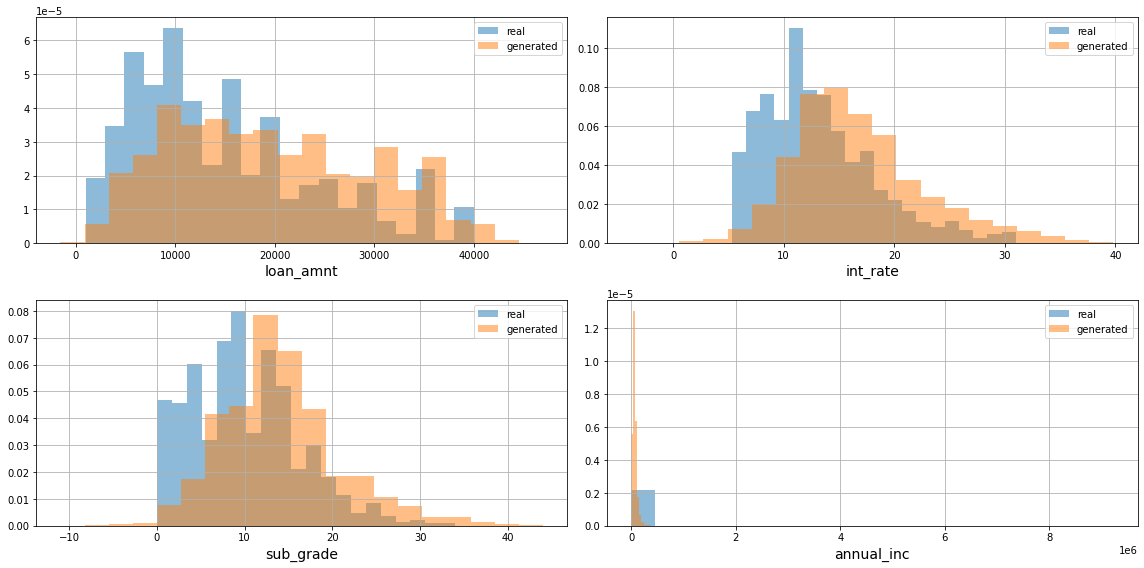

In [98]:
plot_hists(df_xgb_sample[df_xgb_sample.columns[:4]],
          df_svmsmote[df_svmsmote.columns[:4]],
          list(df_svmsmote.columns[:4]),
          'real',
          'generated',
          bins=20)

In [101]:
df_gan_gen_pos = df_svmsmote
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status==1].drop(columns='loan_status').copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9195
median numerical p-value = 1.2429677025457282e-11
invalid numerical ratio = 0.0270
invalid numerical columns ['annual_inc']
invalid overall ratio = 0.6532
Correlation Matrix Distance = 0.0621
quantile 75 of maximum diff between pairwise correlations by columns = 0.0656


In [31]:
df_svmsmote_train['real'] = 0
df_svmsmote_val['real'] = 0
df_svmsmote_test['real'] = 0

x_svmsmote_disc_train = pd.concat([df_true_pos_train, df_svmsmote_train]).reset_index(drop=True)
x_svmsmote_disc_val = pd.concat([df_true_pos_val, df_svmsmote_val]).reset_index(drop=True)
x_svmsmote_disc_test = pd.concat([df_true_pos_test, df_svmsmote_test]).reset_index(drop=True)

y_svmsmote_disc_train = x_svmsmote_disc_train['real']
x_svmsmote_disc_train.drop(columns=['real'], inplace=True)

y_svmsmote_disc_val = x_svmsmote_disc_val['real']
x_svmsmote_disc_val.drop(columns=['real'], inplace=True)

y_svmsmote_disc_test = x_svmsmote_disc_test['real']
x_svmsmote_disc_test.drop(columns=['real'], inplace=True)

In [33]:
y_svmsmote_disc_train.mean()

0.5014422563299028

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [40]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_svmsmote_disc_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_svmsmote_disc_train.columns.values]
x_svmsmote_disc_val.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_svmsmote_disc_val.columns.values]
x_svmsmote_disc_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_svmsmote_disc_test.columns.values]

In [37]:
params = {'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [1, 3],
        'iterations': [100, 200, 300]}
param_list = list(ParameterSampler(param_distributions=params, n_iter=10, random_state=21))
print(param_list[0].keys())

best_f1 = 0
best_params = param_list[0]

with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_svmsmote_disc_train, y=y_svmsmote_disc_train, plot=False,
                   eval_set=[(x_svmsmote_disc_val, y_svmsmote_disc_val)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_svmsmote_disc_val)
        f1_tmp = calc_f1(y_svmsmote_disc_val, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = param_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

dict_keys(['learning_rate', 'l2_leaf_reg', 'iterations', 'depth'])


 10%|█         | 1/10 [00:01<00:12,  1.40s/it]

Test F1 = 0.9620


 20%|██        | 2/10 [00:10<00:49,  6.13s/it]

Test F1 = 0.9916


 30%|███       | 3/10 [00:14<00:34,  4.91s/it]

Test F1 = 0.8651


 40%|████      | 4/10 [00:17<00:26,  4.43s/it]

Test F1 = 0.9319


 50%|█████     | 5/10 [00:18<00:15,  3.19s/it]

Test F1 = 0.5625


 60%|██████    | 6/10 [00:22<00:13,  3.36s/it]

Test F1 = 0.8828


 70%|███████   | 7/10 [00:24<00:08,  2.89s/it]

Test F1 = 0.9640


 80%|████████  | 8/10 [00:26<00:05,  2.55s/it]

Test F1 = 0.7687


 90%|█████████ | 9/10 [00:28<00:02,  2.35s/it]

Test F1 = 0.9206


100%|██████████| 10/10 [00:39<00:00,  3.90s/it]

Test F1 = 0.9527
0.9915772089182494 {'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8}


In [38]:
cb_reg = cbclf(depth=8, l2_leaf_reg=1,
                iterations=300, learning_rate=0.2,
                                    random_state=2023)
cb_reg.fit(X=x_svmsmote_disc_train, y=y_svmsmote_disc_train, plot=False,
       eval_set=[(x_svmsmote_disc_val, y_svmsmote_disc_val)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

Test F1 = 0.9916
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3000
           1       0.99      1.00      0.99      3017

    accuracy                           0.99      6017
   macro avg       0.99      0.99      0.99      6017
weighted avg       0.99      0.99      0.99      6017



In [41]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', # the loss function used
                            use_label_encoder=False, # to remove a warning about future release
                            random_state=42)

xgb_params = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [1, 3],
         'max_depth': [3, 4, 6, 8],
         'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
         'min_child_weight': [1, 3, 5, 10],
         'colsample_bytree': [0.6, 0.8, 1],
         }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)                            
                            
random = RandomizedSearchCV(xgb_clf, 
                            param_distributions=xgb_params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

random.fit(x_svmsmote_disc_train, y_svmsmote_disc_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

KeyboardInterrupt: 

In [43]:
xgb_model_op = xgb.XGBClassifier(objective='binary:logistic',
                                  learning_rate=0.2, 
                                 scale_pos_weight=1,
                                 n_estimators=200,
                                 max_depth=8,
                                 min_child_weight=10,
                                 gamma=1, 
                                 colsample_bytree=0.6,
                                 use_label_encoder=False,
                                 verbose_eval = 20,
                                 random_state=42)

xgb_model_op.fit(x_svmsmote_disc_train, y_svmsmote_disc_train, 
                 verbose=20, 
                 early_stopping_rounds=50,
                 eval_metric='aucpr', 
                 eval_set=[(x_svmsmote_disc_train, y_svmsmote_disc_train), (x_svmsmote_disc_val, y_svmsmote_disc_val)])

y_disc_pred = xgb_model_op.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

[00:39:12] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.80886	validation_1-aucpr:0.78783
[20]	validation_0-aucpr:0.99293	validation_1-aucpr:0.98695
[40]	validation_0-aucpr:0.99808	validation_1-aucpr:0.99409
[60]	validation_0-aucpr:0.99931	validation_1-aucpr:0.99626
[80]	validation_0-aucpr:0.99973	validation_1-aucpr:0.99721
[100]	validation_0-aucpr:0.99992	validation_1-aucpr:0.99841
[120]	validation_0-aucpr:0.99997	validation_1-aucpr:0.99887
[140]	validation_0-aucpr:0.99999	validation_1-aucpr:0.99899
[160]	validation_0-aucpr:0.99999	validation_1-aucpr:0.99909
[180]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99916
[199]	validation_0-aucpr:1.00000	validation

In [44]:
clf = RandomForestClassifier(random_state=0).fit(x_svmsmote_disc_train, y_svmsmote_disc_train)
y_disc_pred = clf.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

Test F1 = 0.9626
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3000
           1       0.95      0.98      0.96      3017

    accuracy                           0.96      6017
   macro avg       0.96      0.96      0.96      6017
weighted avg       0.96      0.96      0.96      6017



In [46]:
clf = LogisticRegression(random_state=0).fit(x_svmsmote_disc_train, y_svmsmote_disc_train)
y_disc_pred = clf.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

Test F1 = 0.6090
              precision    recall  f1-score   support

           0       0.60      0.58      0.59      3000
           1       0.60      0.62      0.61      3017

    accuracy                           0.60      6017
   macro avg       0.60      0.60      0.60      6017
weighted avg       0.60      0.60      0.60      6017



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [47]:
clf = SGDClassifier(random_state=0).fit(x_svmsmote_disc_train, y_svmsmote_disc_train)
y_disc_pred = clf.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

Test F1 = 0.6762
              precision    recall  f1-score   support

           0       0.70      0.21      0.33      3000
           1       0.54      0.91      0.68      3017

    accuracy                           0.56      6017
   macro avg       0.62      0.56      0.50      6017
weighted avg       0.62      0.56      0.50      6017



In [48]:
clf = KNeighborsClassifier().fit(x_svmsmote_disc_train, y_svmsmote_disc_train)
y_disc_pred = clf.predict(x_svmsmote_disc_val)
f1 = calc_f1(y_svmsmote_disc_val, y_disc_pred)
print(classification_report(y_svmsmote_disc_val, y_disc_pred))

Test F1 = 0.5608
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      3000
           1       0.60      0.53      0.56      3017

    accuracy                           0.58      6017
   macro avg       0.58      0.58      0.58      6017
weighted avg       0.58      0.58      0.58      6017



### test to compare with others

In [49]:
y_disc_pred = xgb_model_op.predict(x_svmsmote_disc_test)
f1 = calc_f1(y_svmsmote_disc_test, y_disc_pred)
print(classification_report(y_svmsmote_disc_test, y_disc_pred))

Test F1 = 0.9918
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3000
           1       0.99      1.00      0.99      3018

    accuracy                           0.99      6018
   macro avg       0.99      0.99      0.99      6018
weighted avg       0.99      0.99      0.99      6018



## DPWGAN

In [94]:
df_dpwgan = pd.read_csv('/kaggle/input/final-df-generation/DPWGAN_generated.csv')


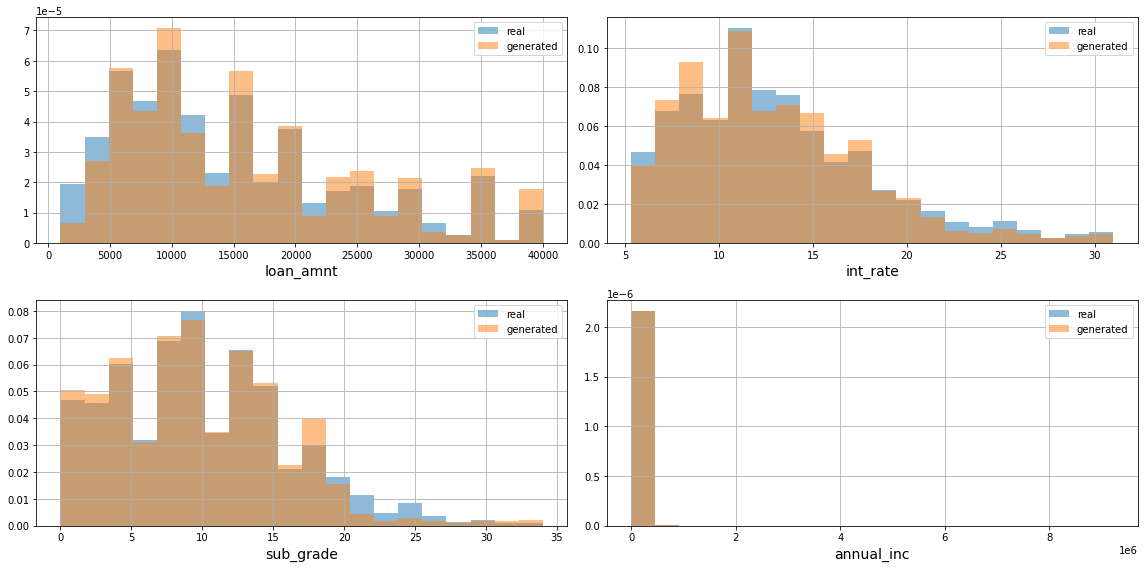

In [95]:
plot_hists(df_xgb_sample[df_xgb_sample.columns[:4]],
          df_dpwgan[df_dpwgan.columns[:4]],
          list(df_dpwgan.columns[:4]),
          'real',
          'generated',
          bins=20)

In [96]:
df_gan_gen_pos = df_dpwgan.loc[df_dpwgan.loan_status==1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status==1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = 1.3936085638930552e-31
invalid numerical ratio = 0.3514
invalid overall ratio = 0.7760
Correlation Matrix Distance = 0.2004
quantile 75 of maximum diff between pairwise correlations by columns = 0.0837


In [97]:
df_gan_gen_pos = df_dpwgan.loc[df_dpwgan.loan_status!=1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status!=1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = 2.3652510028269528e-23
invalid numerical ratio = 0.6216
invalid overall ratio = 0.8560
Correlation Matrix Distance = 0.2033
quantile 75 of maximum diff between pairwise correlations by columns = 0.0775


In [50]:
# create samples for positive discriminator learning
df_dpwgan_pos = df_dpwgan.loc[df_dpwgan.loan_status==1].copy()
df_dpwgan_pos_train = df_dpwgan_pos.sample(int(len(df_dpwgan_pos)*0.7), random_state=2023).drop(columns='loan_status')
df_dpwgan_pos_val = df_dpwgan_pos.loc[~df_dpwgan_pos.index.isin(df_dpwgan_pos_train.index)]\
                                    .sample(int(len(df_dpwgan_pos)*0.15), random_state=2023).drop(columns='loan_status')
df_dpwgan_pos_test = df_dpwgan_pos.loc[(~df_dpwgan_pos.index.isin(df_dpwgan_pos_train.index)) &
                                         (~df_dpwgan_pos.index.isin(df_dpwgan_pos_val.index))].drop(columns='loan_status').copy()
print(len(df_dpwgan_pos_train),
      len(df_dpwgan_pos_val),
      len(df_dpwgan_pos_test))


# create samples for overall discriminator learning
df_dpwgan_train = df_dpwgan.sample(int(len(df_dpwgan)*0.7), random_state=2023)
df_dpwgan_val = df_dpwgan.loc[~df_dpwgan.index.isin(df_dpwgan_train.index)]\
                                    .sample(int(len(df_dpwgan)*0.15), random_state=2023)
df_dpwgan_test = df_dpwgan.loc[(~df_dpwgan.index.isin(df_dpwgan_train.index)) & (~df_dpwgan.index.isin(df_dpwgan_val.index))].copy()
print(len(df_dpwgan_train),
      len(df_dpwgan_val),
      len(df_dpwgan_test))

13748 2946 2946
70000 15000 15000


In [51]:
df_dpwgan_pos_train['real'] = 0
df_dpwgan_pos_val['real'] = 0
df_dpwgan_pos_test['real'] = 0

df_dpwgan_train['real'] = 0
df_dpwgan_val['real'] = 0
df_dpwgan_test['real'] = 0

In [52]:
x_dpwgan_pos_disc_train = pd.concat([df_true_pos_train, df_dpwgan_pos_train]).reset_index(drop=True)
x_dpwgan_pos_disc_val = pd.concat([df_true_pos_val, df_dpwgan_pos_val]).reset_index(drop=True)
x_dpwgan_pos_disc_test = pd.concat([df_true_pos_test, df_dpwgan_pos_test]).reset_index(drop=True)

y_dpwgan_pos_disc_train = x_dpwgan_pos_disc_train['real']
x_dpwgan_pos_disc_train.drop(columns=['real'], inplace=True)

y_dpwgan_pos_disc_val = x_dpwgan_pos_disc_val['real']
x_dpwgan_pos_disc_val.drop(columns=['real'], inplace=True)

y_dpwgan_pos_disc_test = x_dpwgan_pos_disc_test['real']
x_dpwgan_pos_disc_test.drop(columns=['real'], inplace=True)

x_dpwgan_disc_train = pd.concat([df_true_train, df_dpwgan_train]).reset_index(drop=True)
x_dpwgan_disc_val = pd.concat([df_true_val, df_dpwgan_val]).reset_index(drop=True)
x_dpwgan_disc_test = pd.concat([df_true_test, df_dpwgan_test]).reset_index(drop=True)

y_dpwgan_disc_train = x_dpwgan_disc_train['real']
x_dpwgan_disc_train.drop(columns=['real'], inplace=True)

y_dpwgan_disc_val = x_dpwgan_disc_val['real']
x_dpwgan_disc_val.drop(columns=['real'], inplace=True)

y_dpwgan_disc_test = x_dpwgan_disc_test['real']
x_dpwgan_disc_test.drop(columns=['real'], inplace=True)

### positive only

In [55]:
with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_dpwgan_pos_disc_train, y=y_dpwgan_pos_disc_train, plot=False,
                   eval_set=[(x_dpwgan_pos_disc_val, y_dpwgan_pos_disc_val)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_dpwgan_pos_disc_val)
        f1_tmp = calc_f1(y_dpwgan_pos_disc_val, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = param_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

Test F1 = 0.9960


 20%|██        | 2/10 [00:14<01:05,  8.14s/it]

Test F1 = 0.9987


 30%|███       | 3/10 [00:19<00:46,  6.65s/it]

Test F1 = 0.9373


 40%|████      | 4/10 [00:23<00:33,  5.67s/it]

Test F1 = 0.9824


 50%|█████     | 5/10 [00:24<00:20,  4.01s/it]

Test F1 = 0.8149


 60%|██████    | 6/10 [00:29<00:16,  4.23s/it]

Test F1 = 0.9415


 70%|███████   | 7/10 [00:30<00:10,  3.47s/it]

Test F1 = 0.9911


 80%|████████  | 8/10 [00:32<00:06,  3.00s/it]

Test F1 = 0.8215


 90%|█████████ | 9/10 [00:35<00:02,  2.79s/it]

Test F1 = 0.9724


100%|██████████| 10/10 [00:49<00:00,  5.00s/it]

Test F1 = 0.9965
0.9996334677284996 {'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8}


In [56]:
cb_reg = cbclf(depth=8, l2_leaf_reg=1,
                iterations=300, learning_rate=0.2,
                                    random_state=2023)
cb_reg.fit(X=x_dpwgan_pos_disc_train, y=y_dpwgan_pos_disc_train, plot=False,
       eval_set=[(x_dpwgan_pos_disc_val, y_dpwgan_pos_disc_val)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_dpwgan_pos_disc_val)
f1 = calc_f1(y_dpwgan_pos_disc_val, y_disc_pred)
print(classification_report(y_dpwgan_pos_disc_val, y_disc_pred))

Test F1 = 0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2946
           1       1.00      1.00      1.00      3017

    accuracy                           1.00      5963
   macro avg       1.00      1.00      1.00      5963
weighted avg       1.00      1.00      1.00      5963



In [59]:
x_dpwgan_pos_disc_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_dpwgan_pos_disc_train.columns.values]
x_dpwgan_pos_disc_val.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_dpwgan_pos_disc_val.columns.values]
x_dpwgan_pos_disc_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_dpwgan_pos_disc_test.columns.values]

In [60]:
xgb_model_op = xgb.XGBClassifier(objective='binary:logistic',
                                  learning_rate=0.2, 
                                 scale_pos_weight=1,
                                 n_estimators=200,
                                 max_depth=8,
                                 min_child_weight=10,
                                 gamma=1, 
                                 colsample_bytree=0.6,
                                 use_label_encoder=False,
                                 verbose_eval = 20,
                                 random_state=42)

xgb_model_op.fit(x_dpwgan_pos_disc_train, y_dpwgan_pos_disc_train, 
                 verbose=20, 
                 early_stopping_rounds=50,
                 eval_metric='aucpr', 
                 eval_set=[(x_dpwgan_pos_disc_train, y_dpwgan_pos_disc_train), (x_dpwgan_pos_disc_val, y_dpwgan_pos_disc_val)])

y_disc_pred = xgb_model_op.predict(x_dpwgan_pos_disc_val)
f1 = calc_f1(y_dpwgan_pos_disc_val, y_disc_pred)
print(classification_report(y_dpwgan_pos_disc_val, y_disc_pred))

[00:52:50] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86527	validation_1-aucpr:0.85743
[20]	validation_0-aucpr:0.99960	validation_1-aucpr:0.99923
[40]	validation_0-aucpr:0.99998	validation_1-aucpr:0.99990
[60]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99998
[80]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99999
[100]	validation_0-aucpr:1.00000	validation_1-aucpr:0.99999
[120]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000
[140]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000
[160]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000
[170]	validation_0-aucpr:1.00000	validation_1-aucpr:1.00000
Test F1 = 0.9985
              precision   

### test to compare with others

In [61]:
y_disc_pred = xgb_model_op.predict(x_dpwgan_pos_disc_test)
f1 = calc_f1(y_dpwgan_pos_disc_test, y_disc_pred)
print(classification_report(y_dpwgan_pos_disc_test, y_disc_pred))

Test F1 = 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2946
           1       1.00      1.00      1.00      3018

    accuracy                           1.00      5964
   macro avg       1.00      1.00      1.00      5964
weighted avg       1.00      1.00      1.00      5964



### overall

In [53]:
with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_dpwgan_disc_train, y=y_dpwgan_disc_train, plot=False,
                   eval_set=[(x_dpwgan_disc_val, y_dpwgan_disc_val)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_dpwgan_disc_val)
        f1_tmp = calc_f1(y_dpwgan_disc_val, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = param_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

 10%|█         | 1/10 [00:05<00:49,  5.46s/it]

Test F1 = 0.9906


 20%|██        | 2/10 [00:31<02:22, 17.79s/it]

Test F1 = 0.9996


 30%|███       | 3/10 [00:44<01:46, 15.28s/it]

Test F1 = 0.9097


 40%|████      | 4/10 [01:00<01:35, 15.84s/it]

Test F1 = 0.9494


 50%|█████     | 5/10 [01:05<00:58, 11.71s/it]

Test F1 = 0.6699


 60%|██████    | 6/10 [01:20<00:51, 12.92s/it]

Test F1 = 0.9010


 70%|███████   | 7/10 [01:28<00:33, 11.25s/it]

Test F1 = 0.9865


 80%|████████  | 8/10 [01:37<00:21, 10.54s/it]

Test F1 = 0.6686


 90%|█████████ | 9/10 [01:45<00:09,  9.66s/it]

Test F1 = 0.9574


100%|██████████| 10/10 [02:18<00:00, 13.80s/it]

Test F1 = 0.9945
0.9996334677284996 {'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8}


In [62]:
cb_reg = cbclf(depth=8, l2_leaf_reg=1,
                iterations=300, learning_rate=0.2,
                                    random_state=2023)
cb_reg.fit(X=x_dpwgan_disc_train, y=y_dpwgan_disc_train, plot=False,
       eval_set=[(x_dpwgan_disc_val, y_dpwgan_disc_val)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_dpwgan_disc_val)
f1 = calc_f1(y_dpwgan_disc_val, y_disc_pred)
print(classification_report(y_dpwgan_disc_val, y_disc_pred))

Test F1 = 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



### test to compare with others

In [63]:
y_disc_pred = cb_reg.predict(x_dpwgan_disc_test)
f1 = calc_f1(y_dpwgan_disc_test, y_disc_pred)
print(classification_report(y_dpwgan_disc_test, y_disc_pred))

Test F1 = 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



## CTGAN

In [65]:
df_dpwgan = pd.read_csv('/kaggle/input/final-df-generation/CTGAN_df.csv')
df_dpwgan.loan_status.value_counts()

0    92514
1     7486
Name: loan_status, dtype: int64

In [81]:
df_dpwgan.drop(columns='Unnamed: 0', inplace=True)

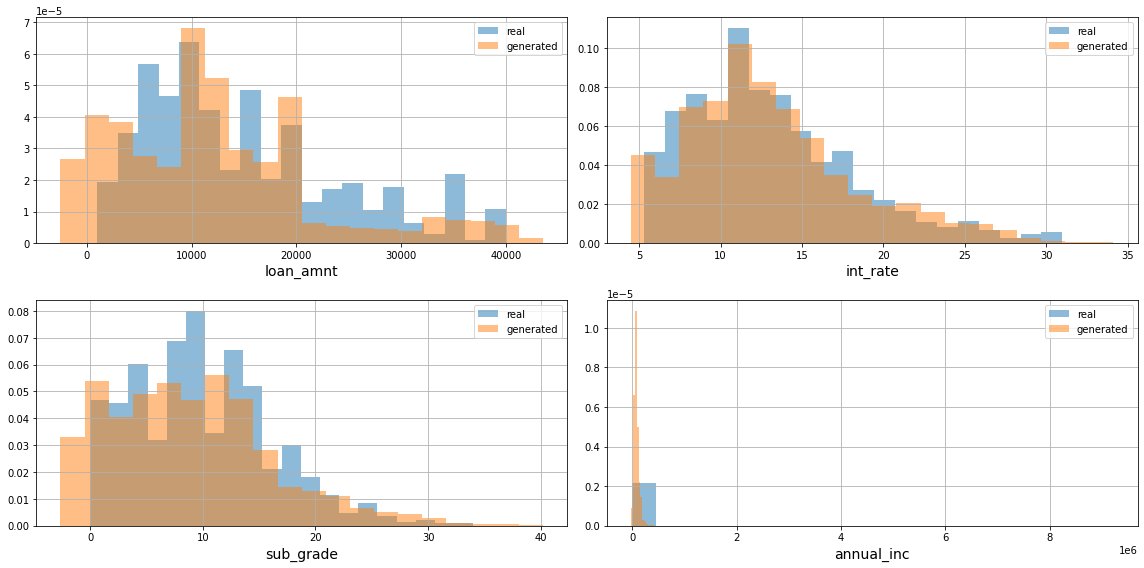

In [82]:
plot_hists(df_xgb_sample[df_xgb_sample.columns[:4]],
          df_dpwgan[df_dpwgan.columns[:4]],
          list(df_dpwgan.columns[:4]),
          'real',
          'generated',
          bins=20)

In [83]:
df_gan_gen_pos = df_dpwgan.loc[df_dpwgan.loan_status==1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status==1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = nan
invalid numerical ratio = 0.0000
invalid numerical columns []
invalid overall ratio = 0.6720


All-NaN slice encountered


Correlation Matrix Distance = 0.2072
quantile 75 of maximum diff between pairwise correlations by columns = 0.0766


In [85]:
df_gan_gen_pos = df_dpwgan.loc[df_dpwgan.loan_status!=1].copy()
df_gan_true_pos = df_xgb_sample.loc[df_xgb_sample.loan_status!=1].copy()

metrics_dict = calc_control_metrics(df_gan_gen_pos, df_gan_true_pos)

divide by zero encountered in log
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars


median binary p-value = 0.0
invalid binary ratio = 0.9545
median numerical p-value = nan
invalid numerical ratio = 0.0000
invalid numerical columns []
invalid overall ratio = 0.6720
Correlation Matrix Distance = 0.2062
quantile 75 of maximum diff between pairwise correlations by columns = 0.0793


In [86]:
df_dpwgan = pd.read_csv('/kaggle/input/final-df-generation/CTGAN_df.csv')
df_dpwgan.drop(columns='Unnamed: 0', inplace=True)
# create samples for positive discriminator learning
df_dpwgan_pos = df_dpwgan.loc[df_dpwgan.loan_status==1].copy()
df_dpwgan_pos_train = df_dpwgan_pos.sample(int(len(df_dpwgan_pos)*0.7), random_state=2023).drop(columns='loan_status')
df_dpwgan_pos_val = df_dpwgan_pos.loc[~df_dpwgan_pos.index.isin(df_dpwgan_pos_train.index)]\
                                    .sample(int(len(df_dpwgan_pos)*0.15), random_state=2023).drop(columns='loan_status')
df_dpwgan_pos_test = df_dpwgan_pos.loc[(~df_dpwgan_pos.index.isin(df_dpwgan_pos_train.index)) &
                                         (~df_dpwgan_pos.index.isin(df_dpwgan_pos_val.index))].drop(columns='loan_status').copy()
print(len(df_dpwgan_pos_train),
      len(df_dpwgan_pos_val),
      len(df_dpwgan_pos_test))


# create samples for overall discriminator learning
df_dpwgan_train = df_dpwgan.sample(int(len(df_dpwgan)*0.7), random_state=2023)
df_dpwgan_val = df_dpwgan.loc[~df_dpwgan.index.isin(df_dpwgan_train.index)]\
                                    .sample(int(len(df_dpwgan)*0.15), random_state=2023)
df_dpwgan_test = df_dpwgan.loc[(~df_dpwgan.index.isin(df_dpwgan_train.index)) & (~df_dpwgan.index.isin(df_dpwgan_val.index))].copy()
print(len(df_dpwgan_train),
      len(df_dpwgan_val),
      len(df_dpwgan_test))

5240 1122 1124
70000 15000 15000


In [88]:
df_dpwgan_pos_train['real'] = 0
df_dpwgan_pos_val['real'] = 0
df_dpwgan_pos_test['real'] = 0

df_dpwgan_train['real'] = 0
df_dpwgan_val['real'] = 0
df_dpwgan_test['real'] = 0

In [89]:
x_dpwgan_pos_disc_train = pd.concat([df_true_pos_train, df_dpwgan_pos_train]).reset_index(drop=True)
x_dpwgan_pos_disc_val = pd.concat([df_true_pos_val, df_dpwgan_pos_val]).reset_index(drop=True)
x_dpwgan_pos_disc_test = pd.concat([df_true_pos_test, df_dpwgan_pos_test]).reset_index(drop=True)

y_dpwgan_pos_disc_train = x_dpwgan_pos_disc_train['real']
x_dpwgan_pos_disc_train.drop(columns=['real'], inplace=True)

y_dpwgan_pos_disc_val = x_dpwgan_pos_disc_val['real']
x_dpwgan_pos_disc_val.drop(columns=['real'], inplace=True)

y_dpwgan_pos_disc_test = x_dpwgan_pos_disc_test['real']
x_dpwgan_pos_disc_test.drop(columns=['real'], inplace=True)

x_dpwgan_disc_train = pd.concat([df_true_train, df_dpwgan_train]).reset_index(drop=True)
x_dpwgan_disc_val = pd.concat([df_true_val, df_dpwgan_val]).reset_index(drop=True)
x_dpwgan_disc_test = pd.concat([df_true_test, df_dpwgan_test]).reset_index(drop=True)

y_dpwgan_disc_train = x_dpwgan_disc_train['real']
x_dpwgan_disc_train.drop(columns=['real'], inplace=True)

y_dpwgan_disc_val = x_dpwgan_disc_val['real']
x_dpwgan_disc_val.drop(columns=['real'], inplace=True)

y_dpwgan_disc_test = x_dpwgan_disc_test['real']
x_dpwgan_disc_test.drop(columns=['real'], inplace=True)

### positive only

In [90]:
with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_dpwgan_pos_disc_train, y=y_dpwgan_pos_disc_train, plot=False,
                   eval_set=[(x_dpwgan_pos_disc_val, y_dpwgan_pos_disc_val)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_dpwgan_pos_disc_val)
        f1_tmp = calc_f1(y_dpwgan_pos_disc_val, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = param_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

 10%|█         | 1/10 [00:01<00:17,  1.96s/it]

Test F1 = 0.9992


 20%|██        | 2/10 [00:15<01:12,  9.03s/it]

Test F1 = 0.9992


 30%|███       | 3/10 [00:21<00:50,  7.26s/it]

Test F1 = 0.9980


 40%|████      | 4/10 [00:24<00:33,  5.65s/it]

Test F1 = 0.9992


 50%|█████     | 5/10 [00:25<00:19,  3.91s/it]

Test F1 = 0.9980


 60%|██████    | 6/10 [00:29<00:15,  3.97s/it]

Test F1 = 0.9980


 70%|███████   | 7/10 [00:30<00:09,  3.13s/it]

Test F1 = 0.9990


 80%|████████  | 8/10 [00:32<00:05,  2.64s/it]

Test F1 = 0.9980


 90%|█████████ | 9/10 [00:35<00:02,  2.71s/it]

Test F1 = 0.9992


100%|██████████| 10/10 [00:49<00:00,  4.98s/it]

Test F1 = 0.9992
1.0 {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 4}


In [91]:
cb_reg = cbclf(depth=4, l2_leaf_reg=1,
                iterations=100, learning_rate=0.1,
                                    random_state=2023)
cb_reg.fit(X=x_dpwgan_pos_disc_train, y=y_dpwgan_pos_disc_train, plot=False,
       eval_set=[(x_dpwgan_pos_disc_val, y_dpwgan_pos_disc_val)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_dpwgan_pos_disc_val)
f1 = calc_f1(y_dpwgan_pos_disc_val, y_disc_pred)
print(classification_report(y_dpwgan_pos_disc_val, y_disc_pred))

Test F1 = 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1122
           1       1.00      1.00      1.00      3017

    accuracy                           1.00      4139
   macro avg       1.00      1.00      1.00      4139
weighted avg       1.00      1.00      1.00      4139



### test to compare with others

In [92]:
y_disc_pred = cb_reg.predict(x_dpwgan_pos_disc_test)
f1 = calc_f1(y_dpwgan_pos_disc_test, y_disc_pred)
print(classification_report(y_dpwgan_pos_disc_test, y_disc_pred))

Test F1 = 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1124
           1       1.00      1.00      1.00      3018

    accuracy                           1.00      4142
   macro avg       1.00      1.00      1.00      4142
weighted avg       1.00      1.00      1.00      4142



### overall

In [93]:
with tqdm(total=len(param_list)) as pbar:
    for i in range(len(param_list)):
        values = [*param_list[i].values()]
        cb_reg = cbclf(depth=values[3], l2_leaf_reg=values[1],
                                    iterations=values[2], learning_rate=values[0],
                                    random_state=2023)
        cb_reg.fit(X=x_dpwgan_disc_train, y=y_dpwgan_disc_train, plot=False,
                   eval_set=[(x_dpwgan_disc_val, y_dpwgan_disc_val)],
                  verbose=False)
        y_disc_pred = cb_reg.predict(x_dpwgan_disc_val)
        f1_tmp = calc_f1(y_dpwgan_disc_val, y_disc_pred)
        if f1_tmp>best_f1:
            best_f1 = f1_tmp
            best_params = param_list[i]
        pbar.update(1)
        
print(best_f1, best_params)

 10%|█         | 1/10 [00:05<00:47,  5.32s/it]

Test F1 = 1.0000


 10%|█         | 1/10 [00:07<01:09,  7.73s/it]


KeyboardInterrupt: 

In [73]:
cb_reg = cbclf(depth=4, l2_leaf_reg=1,
                iterations=100, learning_rate=0.1,
                                    random_state=2023)
cb_reg.fit(X=x_dpwgan_disc_train, y=y_dpwgan_disc_train, plot=False,
       eval_set=[(x_dpwgan_disc_val, y_dpwgan_disc_val)],
      verbose=False)
y_disc_pred = cb_reg.predict(x_dpwgan_disc_val)
f1 = calc_f1(y_dpwgan_disc_val, y_disc_pred)
print(classification_report(y_dpwgan_disc_val, y_disc_pred))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Test F1 = 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



### test to compare with others

In [74]:
y_disc_pred = cb_reg.predict(x_dpwgan_disc_test)
f1 = calc_f1(y_dpwgan_disc_test, y_disc_pred)
print(classification_report(y_dpwgan_disc_test, y_disc_pred))

Test F1 = 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

